# Pyro models

Load data and libraries

In [2]:
import pandas as pd
import numpy as np
from hmmlearn import hmm
import matplotlib.pyplot as plt
from pyprojroot import here
import pyro
import pyro.distributions as dist
import pyro.distributions.constraints as constraints
from pyro.infer import SVI, TraceEnum_ELBO
from pyro.optim import Adam
from scipy.stats import poisson
import torch
import seaborn as sns

data = pd.read_csv(here("data/recent_donations.csv"))
data

# remove columns y_2020 to y_2023
# data = data.drop(columns=["y_2020", "y_2021", "y_2022", "y_2023"])

,unique_number,class_year,birth_year,first_donation_year,gender,y_2009,y_2010,y_2011,y_2012,y_2013,y_2014,y_2015,y_2016,y_2018,y_2019,y_2017,y_2020,y_2021,y_2022,y_2023
0,26308560,"(1960,1970]",1965,1985,M,0,0,0,0,0,0,0,0,0,0,0,1,1,3,1
1,26309283,"(1960,1970]",1966,2002,M,2,1,2,2,1,1,3,3,4,1,3,3,3,3,4
2,26317365,"(1960,1970]",1961,1984,M,4,2,3,3,3,4,3,3,2,3,3,2,0,1,0
3,26318451,"(1960,1970]",1967,1989,M,0,3,3,4,4,4,2,3,3,1,2,3,1,0,0
4,26319465,"(1960,1970]",1964,1994,F,1,2,2,1,2,1,1,0,0,2,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9231,27220599,"(1970,1980]",1980,2022,M,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0
9232,27220806,"(2000,2010]",2002,2022,M,0,0,0,0,0,0,0,0,0,0,0,0,0,2,3
9233,27221247,"(1990,2000]",2000,2022,F,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0
9234,27221274,"(1960,1970]",1966,2022,F,0,0,0,0,0,0,0,0,0,0,0,0,0,2,3


Clean the dataframe and divide it into the time series and the covariates of our model

In [3]:
# ------------------------------------------------------------------
# Required libraries
# ------------------------------------------------------------------
import polars as pl
import numpy as np
import torch

# ------------------------------------------------------------------
# 1. Load data into a Polars DataFrame
# ------------------------------------------------------------------
# df = pl.read_csv("file.csv")          # Uncomment if reading from file
df = pl.from_pandas(data)               # Convert from pandas if already in memory

# ------------------------------------------------------------------
# 2. Collect year columns and build the observation matrix [N, T]
# ------------------------------------------------------------------
year_cols = sorted([c for c in df.columns if c.startswith("y_")])
T = len(year_cols)

obs = (
    df.select(year_cols)                # Select y_* columns
      .fill_null(0)                     # Replace NaNs by 0
      .to_numpy()
      .astype(int)                      # Ensure integer type
)

# ------------------------------------------------------------------
# 3. Create fixed covariates per individual
# ------------------------------------------------------------------
df = df.with_columns(
    [
        (pl.col("gender") == "F").cast(pl.Int8).alias("gender_code"),      # 0 = M, 1 = F
        (
            (pl.col("birth_year") - pl.col("birth_year").mean()) /
            pl.col("birth_year").std()
        ).alias("birth_year_norm")                                         # Standardised birth year
    ]
)

birth_year_norm = df["birth_year_norm"].to_numpy()    # Shape [N]
gender_code     = df["gender_code"].to_numpy()        # Shape [N]

# ------------------------------------------------------------------
# 4. Build dynamic covariates (age and COVID dummy)
# ------------------------------------------------------------------
years_num = np.array([int(c[2:]) for c in year_cols])                 # e.g. [2009, …, 2023]
ages      = years_num[None, :] - df["birth_year"].to_numpy()[:, None] # Shape [N, T]
ages_norm = (ages - ages.mean()) / ages.std()                         # Standardised age

covid_years = np.isin(years_num, [2020, 2021, 2022]).astype(float)    # Shape [T]
covid_years = np.tile(covid_years, (df.height, 1))                    # Shape [N, T]

# ------------------------------------------------------------------
# 5. Assemble the full covariate tensor [N, T, 5]
#    Order: birth_year_norm, gender_code, ages_norm, covid_years, const
# ------------------------------------------------------------------
base_cov  = np.stack([birth_year_norm, gender_code], axis=1)          # Shape [N, 2]
base_cov  = np.repeat(base_cov[:, None, :], T, axis=1)                # [N, T, 2]

dyn_cov   = np.stack([ages_norm, covid_years], axis=2)                # [N, T, 2]

const_cov = np.ones((df.height, T, 1), dtype=np.float32)              # Constant term

full_cov  = np.concatenate([base_cov, dyn_cov, const_cov], axis=2)    # [N, T, 5]
cov_names = ["birth_year_norm",
             "gender_code",
             "ages_norm",
             "covid_years",
             "const"]

# ------------------------------------------------------------------
# 6. Convert to PyTorch tensors (optional)
# ------------------------------------------------------------------
obs_torch      = torch.tensor(obs,      dtype=torch.long)
full_cov_torch = torch.tensor(full_cov, dtype=torch.float)

# ------------------------------------------------------------------
# 7. Quick sanity check
# ------------------------------------------------------------------
print("obs       :", obs.shape)        # (N, T)
print("covariates:", full_cov.shape)   # (N, T, 5)
print("order     :", cov_names)        # Confirm column order

obs       : (9236, 15)
covariates: (9236, 15, 5)
order     : ['birth_year_norm', 'gender_code', 'ages_norm', 'covid_years', 'const']


## HMM without covariates

Let’s start with our models!
First of all, we will start with a Hidden Markov Model. We don’t use a classic HMM with a Gaussian as emission probabilities but a categorical (discrete) emission distribution, where each hidden state emits observable symbols according to its own categorical probability vector.

For inference, we use Stochastic Variational Inference (SVI), which allows us to approximate the posterior distributions of the model parameters efficiently. The optimization is performed using the Adam optimizer, an adaptive learning rate method that helps the model converge quickly and stably during training.

In [5]:
from pyro.infer import SVI, TraceEnum_ELBO  

num_states = 3  # Number of hidden states
num_obs = int(obs_torch.max().item()) + 1

pyro.clear_param_store()  # resetta tutti i parametri!


def model(observations):
    N, T = observations.shape
    num_states = 3

    emission_probs = pyro.param(
        "emission_probs", torch.ones(num_states, num_obs) / num_obs,
        constraint=dist.constraints.simplex)
    trans_probs = pyro.param(
        "trans_probs", torch.ones(num_states, num_states) / num_states,
        constraint=dist.constraints.simplex)
    init_probs = pyro.param(
        "init_probs", torch.ones(num_states) / num_states,
        constraint=dist.constraints.simplex)

    with pyro.plate("individuals", N):
        state = pyro.sample("state_0", dist.Categorical(init_probs))
        for t in range(T):
            pyro.sample(
                f"obs_{t}",
                dist.Categorical(probs=emission_probs[state]),
                obs=observations[:, t]
            )
            if t < T - 1:
                state = pyro.sample(
                    f"state_{t+1}",
                    dist.Categorical(trans_probs[state])
                )

def guide(observations): pass

optimizer = Adam({"lr": 0.05})
svi = SVI(model, guide, optimizer, loss=TraceEnum_ELBO())

for step in range(200):
    loss = svi.step(obs_torch)
    if step % 20 == 0:
        print(f"Loss at step {step}: {loss}")

# Dopo l'allenamento:
emission_probs = pyro.param("emission_probs").detach().cpu().numpy()
trans_probs = pyro.param("trans_probs").detach().cpu().numpy()
init_probs = pyro.param("init_probs").detach().cpu().numpy()
print("Emission probabilities:\n", emission_probs)
print("Transition probabilities:\n", trans_probs)
print("Initial probabilities:\n", init_probs)

C:\Users\erik4\AppData\Local\Programs\Python\Python313\Lib\site-packages\pyro\util.py:303: UserWarning: Found vars in model but not guide: {'state_0', 'state_9', 'state_12', 'state_5', 'state_10', 'state_8', 'state_11', 'state_7', 'state_13', 'state_2', 'state_3', 'state_4', 'state_6', 'state_14', 'state_1'}
  warnings.warn(f"Found vars in model but not guide: {bad_sites}")
C:\Users\erik4\AppData\Local\Programs\Python\Python313\Lib\site-packages\pyro\infer\traceenum_elbo.py:355: UserWarning: TraceEnum_ELBO found no sample sites configured for enumeration. If you want to enumerate sites, you need to @config_enumerate or set infer={"enumerate": "sequential"} or infer={"enumerate": "parallel"}? If you do not want to enumerate, consider using Trace_ELBO instead.
  warnings.warn(


Loss at step 0: 400431.4375


C:\Users\erik4\AppData\Local\Programs\Python\Python313\Lib\site-packages\pyro\util.py:303: UserWarning: Found vars in model but not guide: {'state_0', 'state_9', 'state_12', 'state_5', 'state_10', 'state_8', 'state_11', 'state_7', 'state_13', 'state_2', 'state_3', 'state_4', 'state_6', 'state_14', 'state_1'}
  warnings.warn(f"Found vars in model but not guide: {bad_sites}")
C:\Users\erik4\AppData\Local\Programs\Python\Python313\Lib\site-packages\pyro\infer\traceenum_elbo.py:355: UserWarning: TraceEnum_ELBO found no sample sites configured for enumeration. If you want to enumerate sites, you need to @config_enumerate or set infer={"enumerate": "sequential"} or infer={"enumerate": "parallel"}? If you do not want to enumerate, consider using Trace_ELBO instead.
  warnings.warn(
C:\Users\erik4\AppData\Local\Programs\Python\Python313\Lib\site-packages\pyro\util.py:303: UserWarning: Found vars in model but not guide: {'state_0', 'state_9', 'state_12', 'state_5', 'state_10', 'state_8', 'state

Loss at step 20: 324836.59375
Loss at step 40: 308201.3125
Loss at step 60: 300125.6875
Loss at step 80: 293831.375
Loss at step 100: 284797.09375


C:\Users\erik4\AppData\Local\Programs\Python\Python313\Lib\site-packages\pyro\util.py:303: UserWarning: Found vars in model but not guide: {'state_0', 'state_9', 'state_12', 'state_5', 'state_10', 'state_8', 'state_11', 'state_7', 'state_13', 'state_2', 'state_3', 'state_4', 'state_6', 'state_14', 'state_1'}
  warnings.warn(f"Found vars in model but not guide: {bad_sites}")
C:\Users\erik4\AppData\Local\Programs\Python\Python313\Lib\site-packages\pyro\infer\traceenum_elbo.py:355: UserWarning: TraceEnum_ELBO found no sample sites configured for enumeration. If you want to enumerate sites, you need to @config_enumerate or set infer={"enumerate": "sequential"} or infer={"enumerate": "parallel"}? If you do not want to enumerate, consider using Trace_ELBO instead.
  warnings.warn(
C:\Users\erik4\AppData\Local\Programs\Python\Python313\Lib\site-packages\pyro\util.py:303: UserWarning: Found vars in model but not guide: {'state_0', 'state_9', 'state_12', 'state_5', 'state_10', 'state_8', 'state

Loss at step 120: 284374.90625


C:\Users\erik4\AppData\Local\Programs\Python\Python313\Lib\site-packages\pyro\util.py:303: UserWarning: Found vars in model but not guide: {'state_0', 'state_9', 'state_12', 'state_5', 'state_10', 'state_8', 'state_11', 'state_7', 'state_13', 'state_2', 'state_3', 'state_4', 'state_6', 'state_14', 'state_1'}
  warnings.warn(f"Found vars in model but not guide: {bad_sites}")
C:\Users\erik4\AppData\Local\Programs\Python\Python313\Lib\site-packages\pyro\infer\traceenum_elbo.py:355: UserWarning: TraceEnum_ELBO found no sample sites configured for enumeration. If you want to enumerate sites, you need to @config_enumerate or set infer={"enumerate": "sequential"} or infer={"enumerate": "parallel"}? If you do not want to enumerate, consider using Trace_ELBO instead.
  warnings.warn(
C:\Users\erik4\AppData\Local\Programs\Python\Python313\Lib\site-packages\pyro\infer\traceenum_elbo.py:355: UserWarning: TraceEnum_ELBO found no sample sites configured for enumeration. If you want to enumerate site

Loss at step 140: 288510.96875


C:\Users\erik4\AppData\Local\Programs\Python\Python313\Lib\site-packages\pyro\util.py:303: UserWarning: Found vars in model but not guide: {'state_0', 'state_9', 'state_12', 'state_5', 'state_10', 'state_8', 'state_11', 'state_7', 'state_13', 'state_2', 'state_3', 'state_4', 'state_6', 'state_14', 'state_1'}
  warnings.warn(f"Found vars in model but not guide: {bad_sites}")
C:\Users\erik4\AppData\Local\Programs\Python\Python313\Lib\site-packages\pyro\infer\traceenum_elbo.py:355: UserWarning: TraceEnum_ELBO found no sample sites configured for enumeration. If you want to enumerate sites, you need to @config_enumerate or set infer={"enumerate": "sequential"} or infer={"enumerate": "parallel"}? If you do not want to enumerate, consider using Trace_ELBO instead.
  warnings.warn(


Loss at step 160: 280958.875


C:\Users\erik4\AppData\Local\Programs\Python\Python313\Lib\site-packages\pyro\util.py:303: UserWarning: Found vars in model but not guide: {'state_0', 'state_9', 'state_12', 'state_5', 'state_10', 'state_8', 'state_11', 'state_7', 'state_13', 'state_2', 'state_3', 'state_4', 'state_6', 'state_14', 'state_1'}
  warnings.warn(f"Found vars in model but not guide: {bad_sites}")
C:\Users\erik4\AppData\Local\Programs\Python\Python313\Lib\site-packages\pyro\infer\traceenum_elbo.py:355: UserWarning: TraceEnum_ELBO found no sample sites configured for enumeration. If you want to enumerate sites, you need to @config_enumerate or set infer={"enumerate": "sequential"} or infer={"enumerate": "parallel"}? If you do not want to enumerate, consider using Trace_ELBO instead.
  warnings.warn(


Loss at step 180: 276805.875


C:\Users\erik4\AppData\Local\Programs\Python\Python313\Lib\site-packages\pyro\util.py:303: UserWarning: Found vars in model but not guide: {'state_0', 'state_9', 'state_12', 'state_5', 'state_10', 'state_8', 'state_11', 'state_7', 'state_13', 'state_2', 'state_3', 'state_4', 'state_6', 'state_14', 'state_1'}
  warnings.warn(f"Found vars in model but not guide: {bad_sites}")
C:\Users\erik4\AppData\Local\Programs\Python\Python313\Lib\site-packages\pyro\infer\traceenum_elbo.py:355: UserWarning: TraceEnum_ELBO found no sample sites configured for enumeration. If you want to enumerate sites, you need to @config_enumerate or set infer={"enumerate": "sequential"} or infer={"enumerate": "parallel"}? If you do not want to enumerate, consider using Trace_ELBO instead.
  warnings.warn(


Emission probabilities:
 [[0.5666607  0.19347118 0.14834104 0.07155315 0.01550294 0.00447095]
 [0.5682594  0.1939444  0.14714856 0.07131724 0.01577074 0.00355964]
 [0.58102167 0.18673871 0.14169626 0.07110254 0.015733   0.00370782]]
Transition probabilities:
 [[0.49828446 0.26471248 0.23700307]
 [0.10383585 0.16157764 0.73458654]
 [0.14641745 0.8048122  0.04877038]]
Initial probabilities:
 [0.16284195 0.19725384 0.6399042 ]


We define a function to plot easily the parameters of the model just trained. In the plot there are the three main components of a HMM:
the initial state probabilities, the transition matrix between hidden states, and the emission probabilities.

In this case, the initial state distribution suggests that most individuals start in state 1, indicating a possible homogeneity at the beginning of the observed period. 
The transition matrix reveals that state 0 is relatively stable (high self-transition probability), while state 1 tends to transition to state 0, and state 2 to state 1, suggesting a possible progression or hierarchy among the states. However, the emission probabilities are very similar across states, which indicates that the model struggles to distinguish between the latent states based on the observed data. 
This lack of separation is also reflected in the transition matrix suggesting frequent transitions between states. Overall, this may point to either insufficient information in the observations to clearly identify distinct latent states, or to a model with more states than necessary for the data.



In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_hmm_params(transitions, initial_probs, emissions,
                    state_names=None, emission_names=None):
    """
    Plotta in una riga:
    - Matrice di transizione [S, S]
    - Prob iniziali [S]
    - Matrice emissioni [S, K]
    """
    S = len(initial_probs)
    K = emissions.shape[1]
    if state_names is None:
        state_names = [f"State {i}" for i in range(S)]
    if emission_names is None:
        emission_names = [str(i) for i in range(K)]

    fig, axs = plt.subplots(1, 3, figsize=(15, 3))

    # Initial probabilities
    axs[0].bar(np.arange(S), initial_probs, color='royalblue')
    axs[0].set_title('Initial State Probabilities')
    axs[0].set_xlabel('State')
    axs[0].set_ylabel('Probability')
    axs[0].set_xticks(np.arange(S))
    axs[0].set_xticklabels(state_names)
    axs[0].grid(axis='y', alpha=0.3)

    # Transition matrix
    sns.heatmap(transitions, annot=True, fmt=".2f", cmap='Greens',
                xticklabels=state_names, yticklabels=state_names, ax=axs[1], cbar=False)
    axs[1].set_title('Transition Probabilities')
    axs[1].set_xlabel('Next State')
    axs[1].set_ylabel('Current State')

    # Emission probabilities/matrix
    sns.heatmap(emissions, annot=True, fmt=".2f", cmap='Blues',
                xticklabels=emission_names, yticklabels=state_names, ax=axs[2], cbar=False)
    axs[2].set_title('Emission Probabilities')
    axs[2].set_xlabel('Donations in a Year')
    axs[2].set_ylabel('Latent State')

    plt.tight_layout()
    plt.show()

# Plot the learned parameters
plot_hmm_params(
    transitions=trans_probs,
    initial_probs=init_probs,
    emissions=emission_probs)

NameError: name 'trans_probs' is not defined

State occupancy over time (population view)

In [13]:
# Viterbi or posterior-sample paths: paths -> (N,T) ints
counts = np.apply_along_axis(lambda col: np.bincount(col, minlength=K),
                             0, paths)          # (K,T)
props  = counts / counts.sum(0, keepdims=True)

plt.figure(figsize=(8,4))
for k,c in enumerate(['tab:orange','tab:blue','tab:green']):
    plt.plot(props[k], label=f'state {k}', color=c)
plt.xlabel('year index'); plt.ylabel('population share')
plt.title('State occupancy over time'); plt.legend(); plt.tight_layout()

NameError: name 'paths' is not defined

In [14]:
flat_x = obs_torch.flatten().cpu().numpy()
flat_z = paths.flatten()
sns.violinplot(x=flat_z, y=flat_x, inner="quartile")
plt.xlabel('latent state'); plt.ylabel('# donations')
plt.title('Observed donations given latent state')

NameError: name 'paths' is not defined

## Full Pyro

### Poisson

In this section, unlike the previous approach, we explicitly define prior distributions for the HMM parameters (initial state, transition matrix, emission rates) using pyro.sample. The guide function introduces variational distributions (with learnable parameters) for these latent variables, enabling fully Bayesian inference via SVI. This allows us to incorporate prior knowledge and quantify uncertainty over the model parameters.

Model  
- 3-state Poisson Hidden Markov Model.  

  $$\pi \sim \text{Dirichlet}(\mathbf 1)$$  
  $$A_{k\cdot} \sim \text{Dirichlet}(\mathbf 1)\quad\forall k$$  
  $$z_0 \sim \text{Categorical}(\pi),\qquad 
    z_t\mid z_{t-1}\sim\text{Categorical}(A_{z_{t-1}\cdot})$$  
  $$\lambda_k \sim \text{Gamma}(2,1)$$  
  $$y_t \mid z_t=k \sim \text{Poisson}(\lambda_k)$$  

  Discrete chains $z_{n,t}$ are marginalised exactly via enumeration.

Guide (mean-field)  
  $$q(\pi)=\text{Dirichlet}(\boldsymbol{\alpha}_\pi),\qquad 
    q(A_{k\cdot})=\text{Dirichlet}(\boldsymbol{\alpha}_{A_k}),\qquad
    q(\lambda_k)=\text{Gamma}(\alpha_k,\beta_k)$$  

  Hence $$q(\pi,A,\lambda)=q(\pi)\prod_k q(A_{k\cdot})q(\lambda_k)$$ with no cross-covariances; $z$’s remain exact.

Training  
- Stochastic Variational Inference, Adam (lr = 0.05).  
- Objective: TraceEnum_ELBO(max_plate_nesting = 1).  
- ELBO descends from ≈174 k to ≈130 k; posterior means $\hat\pi$, $\hat A$, $\hat\lambda$ are reported together with their Dirichlet/Gamma uncertainty. 

In [11]:
K = 3              # n. stati latenti


# ------------------------------------------------------------------ #
#  MODEL                                                             #
# ------------------------------------------------------------------ #
def model(obs):
    N, T = obs.shape

    # π   (prob. iniziali)  – una sola Dirichlet
    pi = pyro.sample("pi", dist.Dirichlet(torch.ones(K)))              # [K]

    # A   (matrice di transizione)  – K Dirichlet, una per riga
    with pyro.plate("row", K):
        A = pyro.sample("A", dist.Dirichlet(torch.ones(K)))            # [K,K]

    # tassi Poisson
    rates = pyro.sample("rates",
                        dist.Gamma(2.*torch.ones(K),
                                   1.*torch.ones(K)).to_event(1))      # [K]

    # osservazioni
    with pyro.plate("donor", N):
        z = pyro.sample("z_0", dist.Categorical(pi),
                        infer={"enumerate": "parallel"})

        for t in pyro.markov(range(T)):
            pyro.sample(f"y_{t}", dist.Poisson(rates[z]),
                        obs=obs[:, t])
            if t < T-1:
                z = pyro.sample(f"z_{t+1}", dist.Categorical(A[z]),
                                infer={"enumerate": "parallel"})


# ------------------------------------------------------------------ #
#  GUIDE                                                             #
# ------------------------------------------------------------------ #
def guide(obs):
    # variational params
    pi_alpha    = pyro.param("pi_alpha",
                             torch.ones(K),
                             constraint=dist.constraints.positive)     # [K]

    A_alpha     = pyro.param("A_alpha",
                             torch.ones(K, K),
                             constraint=dist.constraints.positive)     # [K,K]

    r_alpha     = pyro.param("r_alpha",
                             2.*torch.ones(K),
                             constraint=dist.constraints.positive)     # [K]
    r_beta      = pyro.param("r_beta",
                             1.*torch.ones(K),
                             constraint=dist.constraints.positive)

    pyro.sample("pi", dist.Dirichlet(pi_alpha))

    with pyro.plate("row", K):
        pyro.sample("A", dist.Dirichlet(A_alpha))

    pyro.sample("rates", dist.Gamma(r_alpha, r_beta).to_event(1))


# ------------------------------------------------------------------ #
#  TRAINING                                                          #
# ------------------------------------------------------------------ #
pyro.clear_param_store()
svi = SVI(model, guide, Adam({"lr": 0.05}),
          loss=TraceEnum_ELBO(max_plate_nesting=1))

for step in range(1000):
    loss = svi.step(obs_torch)
    if step % 100 == 0:
        print(f"{step:4d}  ELBO = {loss:,.0f}")


# ------------------------------------------------------------------ #
#  PARAMETRI “MEAN” DOPO IL TRAINING                                 #
# ------------------------------------------------------------------ #
with torch.no_grad():
    pi_mean = pyro.param("pi_alpha")
    pi_mean = pi_mean / pi_mean.sum()

    A_alpha = pyro.param("A_alpha")
    A_mean  = A_alpha / A_alpha.sum(dim=1, keepdim=True)   # somma 1 per riga

    rates   = pyro.param("r_alpha") / pyro.param("r_beta")

print("\nπ:", pi_mean.numpy())
print("\nA (ogni riga somma a 1):\n", A_mean.numpy())
print("\nrates:", rates.numpy())

   0  ELBO = 173,914
 100  ELBO = 161,650
 200  ELBO = 135,656
 300  ELBO = 144,151
 400  ELBO = 136,294
 500  ELBO = 137,679
 600  ELBO = 132,872
 700  ELBO = 132,589
 800  ELBO = 130,442
 900  ELBO = 131,066

π: [0.7436053  0.17772424 0.07867038]

A (ogni riga somma a 1):
 [[0.88173765 0.0285709  0.0896915 ]
 [0.00360092 0.97527295 0.02112615]
 [0.00552198 0.00395451 0.99052346]]

rates: [0.00598985 2.4172876  0.83182895]


• ELBO steadily decreases from ≈174 k to ≈130 k and then plateaus → optimisation has mostly converged.

• Initial-state distribution π
– State 0 dominates (74 %), followed by state 1 (18 %); state 2 is rare (8 %).
– Most donors start in state 0.

• Transition matrix A
– Strong self-persistence: P(0 → 0)=0.88, P(1 → 1)=0.98, P(2 → 2)=0.99.
– Cross-state moves are all < 9 %; once a donor is in a state, they tend to stay there.

• Poisson rates
– State 0: λ≈0.006 (almost no donations)
– State 1: λ≈2.42 (frequent donors)
– State 2: λ≈0.83 (occasional donors)

Interpretation: the model has discovered three very stable behavioural profiles—non-donors, heavy donors, and light donors—with rare transitions between them.

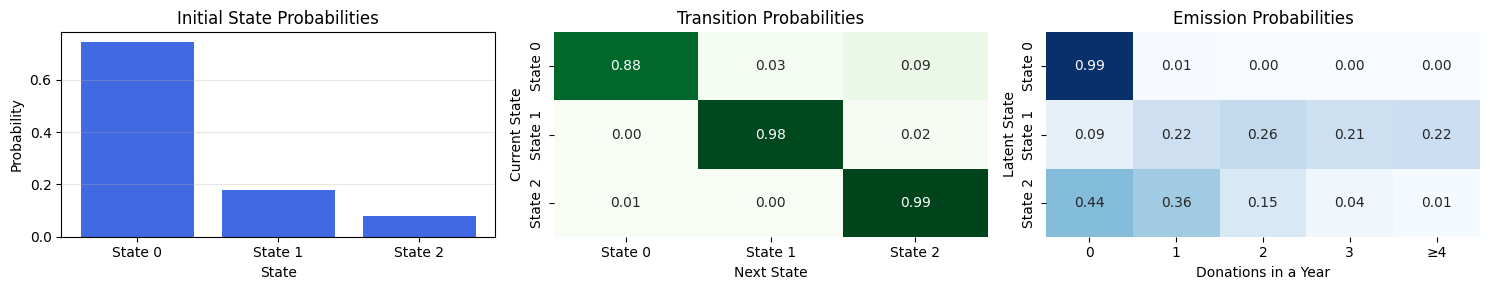

In [12]:
def build_emission_matrix_truncated_poisson(rates, max_k=4):
    S = len(rates)
    K = max_k + 1   # da 0 a max_k incluso
    emissions = np.zeros((S, K))
    for s in range(S):
        for k in range(max_k):
            emissions[s, k] = poisson.pmf(k, rates[s])
        # L'ultimo raccoglie la coda (tutto >= max_k)
        emissions[s, max_k] = 1 - poisson.cdf(max_k-1, rates[s])
    return emissions

emissions_matrix = build_emission_matrix_truncated_poisson(rates, max_k=4)

plot_hmm_params(
    transitions=A_mean,
    initial_probs=pi_mean,
    emissions=emissions_matrix,
    emission_names=[str(i) for i in range(4)] + ["≥4"]
)

#### Viterbi algorithm

Viterbi decoder  
Goal : for each donor find the MAP latent path $z_{0:T}^\ast$.  

Plug-in parameters (posterior means)  
$$\hat\pi_k = \frac{\alpha_{\pi,k}}{\sum_{j}\alpha_{\pi,j}},\qquad
  \hat A_{kj} = \frac{\alpha_{A_{k j}}}{\sum_{j'}\alpha_{A_{k j'}}},\qquad
  \hat\lambda_k = \frac{\alpha_k}{\beta_k}.$$

Dynamic programming  
Initial step  
$$\delta_0(k)=\log\hat\pi_k+\log\text{Poisson}(y_0\mid\hat\lambda_k).$$  

Recursion for $t=1,\dots,T$  
$$\delta_t(j)=\max_k\bigl[\delta_{t-1}(k)+\log\hat A_{k j}\bigr]
               +\log\text{Poisson}(y_t\mid\hat\lambda_j),$$  
$$\psi_t(j)=\arg\max_k\bigl[\delta_{t-1}(k)+\log\hat A_{k j}\bigr].$$  

Back-tracking  
Start with $z_T^\ast=\arg\max_k\delta_T(k)$, then  
$z_{t-1}^\ast=\psi_t(z_t^\ast)$ for $t=T,\dots,1$.

Cost $O(NTK^2)$ but vectorised in PyTorch, so only a loop on $t$.  
Output tensor paths[N,T] of integers 0…K-1, used for diagnostics and plots. 

In [17]:
def viterbi_paths_poisson(obs,      # LongTensor [N,T]
                          K=3):     # # latent states
    """
    Returns the most-likely latent path for every individual
    using the current variational parameters of the Poisson HMM.
    """
    with torch.no_grad():
        # ----- expected model parameters ---------------------------------
        # initial probs π
        pi_alpha = pyro.param("pi_alpha")                  # [K]
        pi_prob  = pi_alpha / pi_alpha.sum()               # [K]
        log_pi   = pi_prob.log()

        # transition matrix A
        A_alpha  = pyro.param("A_alpha")                   # [K,K]
        A_prob   = A_alpha / A_alpha.sum(1, keepdim=True)  # rows sum 1
        log_A    = A_prob.log()

        # Poisson rates λ
        r_alpha  = pyro.param("r_alpha")                   # [K]
        r_beta   = pyro.param("r_beta")
        rates    = r_alpha / r_beta                       # [K]

        # ----- pre-compute emission log-probs ----------------------------
        N, T = obs.shape
        emis_log = dist.Poisson(rates).log_prob(obs.unsqueeze(-1))  # (N,T,K)

        # ----- Viterbi ----------------------------------------------------
        paths  = torch.zeros(N, T, dtype=torch.long)
        psi    = torch.zeros(N, T, K, dtype=torch.long)   # back-pointers
        delta  = log_pi + emis_log[:, 0]                  # (N,K)

        for t in range(1, T):
            # score: delta_prev + log A (broadcast prev→next)
            score = delta.unsqueeze(2) + log_A            # (N,K_prev,K_next)
            delta, psi[:, t] = torch.max(score, dim=1)    # argmax over prev
            delta += emis_log[:, t]                       # add emission

        # back-tracking
        last = torch.argmax(delta, dim=1)                 # (N,)
        paths[:, -1] = last
        for t in range(T - 1, 0, -1):
            last = psi[torch.arange(N), t, last]
            paths[:, t-1] = last

    return paths


# -------------------------------------------------------------------------
paths = viterbi_paths_poisson(obs_torch, K=3).cpu().numpy()

# e.g. fraction of sequences that switch state at least once
switch = (paths[:, 1:] != paths[:, :-1]).any(1).mean()
print(f"Sequences with ≥1 switch: {switch * 100:.1f}%")

Sequences with ≥1 switch: 80.3%


##### State occupancy over time (population view)

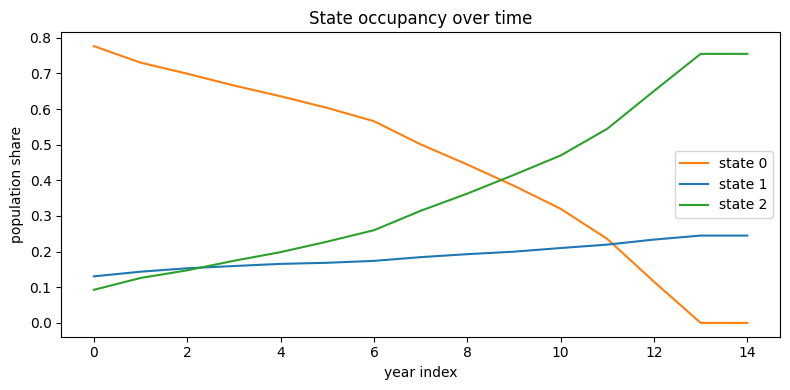

In [18]:
counts = np.apply_along_axis(lambda col: np.bincount(col, minlength=3),
                             0, paths)          # (K,T)
props  = counts / counts.sum(0, keepdims=True)

plt.figure(figsize=(8,4))
for k,c in enumerate(['tab:orange','tab:blue','tab:green']):
    plt.plot(props[k], label=f'state {k}', color=c)
plt.xlabel('year index'); plt.ylabel('population share')
plt.title('State occupancy over time'); plt.legend(); plt.tight_layout()

##### Rates with confidence bands

Text(0.5, 1.0, 'Poisson rates with 95% CI')

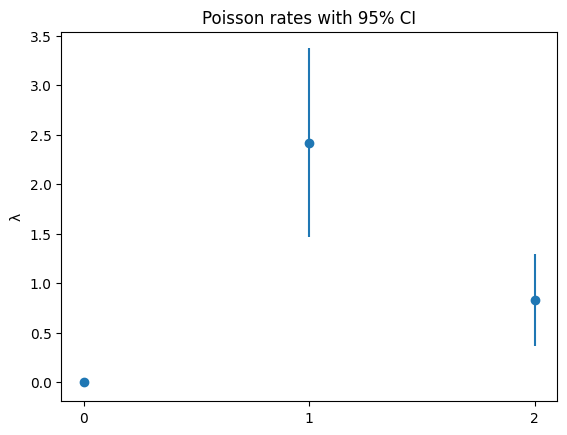

In [25]:

rate_sd   = np.sqrt(pyro.param("r_alpha").detach().numpy()) / pyro.param("r_beta").detach().numpy()
ci = 1.96 * rate_sd
plt.errorbar(np.arange(K), rates, yerr=ci, fmt='o')
plt.xticks(range(K)); plt.ylabel('λ'); plt.title('Poisson rates with 95% CI')

##### Network / chord diagram of transitions

A visual alternative to the heat-map, highlights main flows.

C:\Users\erik4\AppData\Local\Programs\Python\Python313\Lib\site-packages\networkx\drawing\nx_pylab.py:457: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


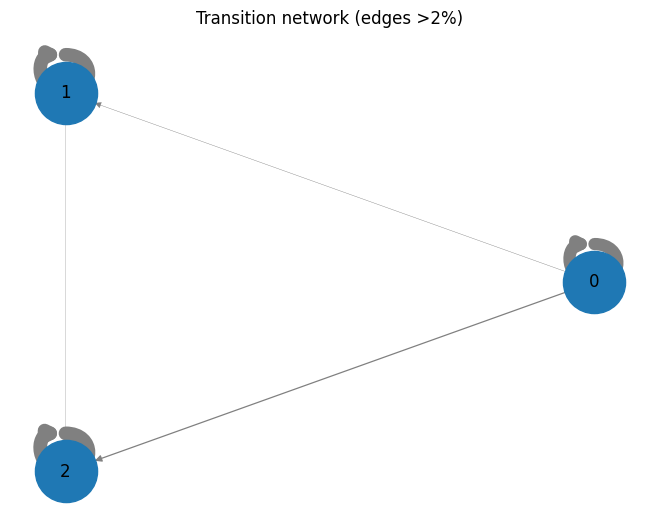

In [26]:
import networkx as nx
G = nx.DiGraph()
for i in range(K):
    for j in range(K):
        if A_mean[i,j] > 0.02:                 # ignore tiny flows
            G.add_edge(i, j, weight=A_mean[i,j])
pos = nx.circular_layout(G)
weights = [G[u][v]['weight']*10 for u,v in G.edges]
nx.draw(G, pos, with_labels=True, width=weights,
        edge_color='grey', node_size=2000, cmap='viridis')
plt.title('Transition network (edges >2%)'); plt.show()

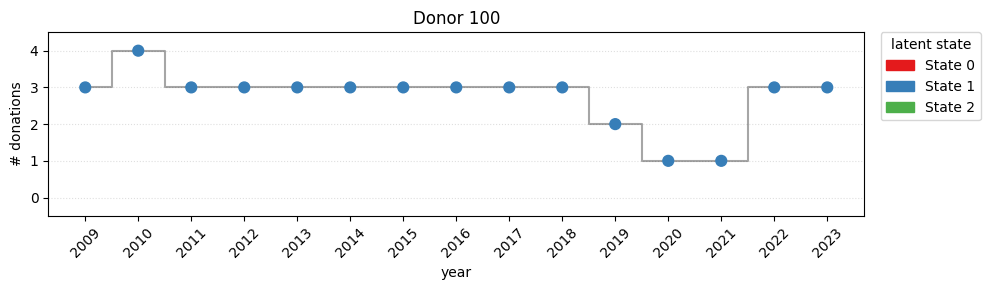

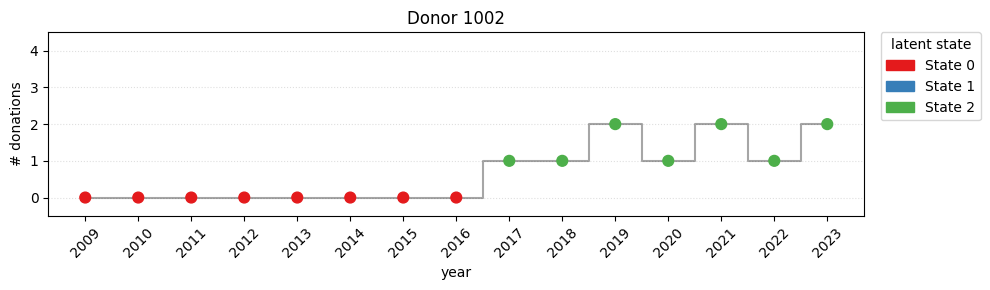

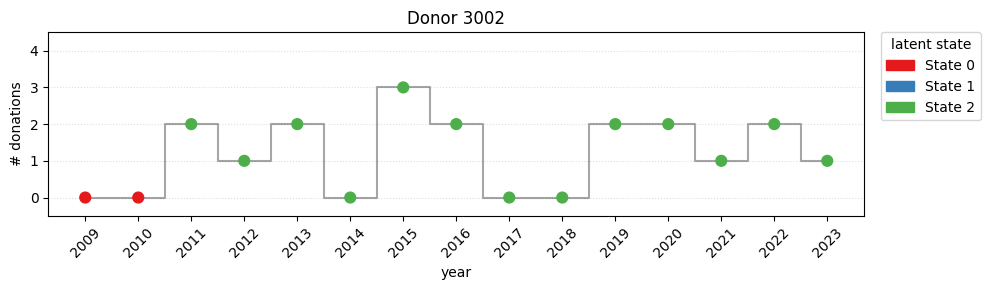

In [44]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.patches import Patch
import numpy as np

# ------------------------------------------------------------
# globals
# ------------------------------------------------------------
K           = 3
state_cols  = ['#e41a1c', '#377eb8', '#4daf4a']          # 3 colori Set1
cmap        = ListedColormap(state_cols)
norm        = BoundaryNorm(np.arange(-0.5, K+0.5, 1), cmap.N)
years_axis  = np.arange(2009, 2024)                      # 2009 .. 2024
yticks_vals = np.arange(0, 5)                            # 0 .. 4

# ------------------------------------------------------------
def plot_one(idx):
    x = obs_torch[idx].cpu().numpy()       # osservazioni (T,)
    z = paths[idx]                         # stati latenti (T,)
    T = len(x)
    assert T == len(years_axis), "years_axis length must match T"

    plt.figure(figsize=(10, 3))
    plt.scatter(range(T), x, c=z, cmap=cmap, norm=norm, s=60, zorder=3)
    plt.step(range(T), x, where='mid', color='k', alpha=.35, zorder=2)

    # ---------- axis formatting ----------------------------------------
    plt.xticks(ticks=range(T), labels=years_axis, rotation=45)
    plt.yticks(ticks=yticks_vals)
    plt.ylim(-0.5, 4.5)                     # blocca a 0–4
    plt.grid(axis='y', linestyle=':', alpha=.4, zorder=1)

    # ---------- legenda discreta ---------------------------------------
    handles = [Patch(color=state_cols[k], label=f'State {k}') for k in range(K)]
    plt.legend(handles=handles, title='latent state',
               bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0.)

    plt.title(f'Donor {idx}')
    plt.xlabel('year')
    plt.ylabel('# donations')
    plt.tight_layout()
    plt.show()


for i in [100, 1002, 3002]:
    plot_one(i)

##### Stationary distribution vs initial π

Compute the stationary distribution of A and plot both as bars.

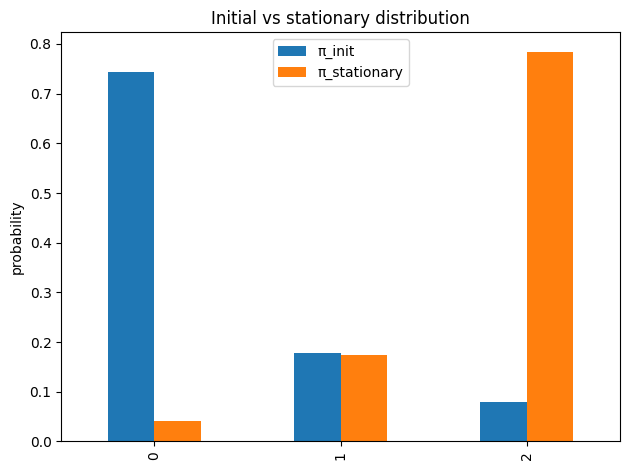

In [39]:
w, v = np.linalg.eig(A_mean.T)
stationary = np.real(v[:,np.isclose(w,1)].flatten())
stationary /= stationary.sum()
df = pd.DataFrame({'π_init':pi_mean, 'π_stationary':stationary})
df.plot(kind='bar'); plt.ylabel('probability')
plt.title('Initial vs stationary distribution'); plt.tight_layout()

### Testing

Actually, this model is the best one, looking the loss. Maybe for the prior 

In [274]:
# Dati finti, gli do una prior per fare testing
pi_true = torch.tensor([[0.00198279, 0.14994904, 0.84806824]])
A_true = torch.tensor([[1.4430614e-01, 1.8874713e-04, 1.1168744e-03],
 [8.4352428e-03, 2.5033113e-01, 4.1714776e-04],
 [5.7374258e-02, 1.8518262e-02, 5.1931220e-01]])
rates_true = torch.tensor([0.780297,   2.0785418,  0.00218539])
states = [torch.multinomial(pi_true, 1).item()]

def model(observations):
    N, T = observations.shape
    num_states = 3
    pi = pyro.sample("pi", dist.Dirichlet(torch.ones(num_states)))
    A = pyro.sample("A", dist.Dirichlet(torch.ones(num_states, num_states)).to_event(1))
    rates = pyro.sample("rates", dist.Gamma(2.0 * torch.ones(num_states), torch.ones(num_states)).to_event(1))
    with pyro.plate("donors", N):
        x = pyro.sample("PD_0", dist.Categorical(pi), infer={"enumerate": "parallel"})
        for t in pyro.markov(range(T)):
            x = pyro.sample(f"PD_{t+1}", dist.Categorical(A[x]), infer={"enumerate": "parallel"})
            pyro.sample(f"ND_{t}", dist.Poisson(rates[x]), obs=observations[:, t])

def guide(observations):
    num_states = 3
    pi_alpha = pyro.param("pi_alpha", torch.ones(num_states), constraint=dist.constraints.positive)
    A_alpha = pyro.param("A_alpha", torch.ones(num_states, num_states), constraint=dist.constraints.positive)
    rates_alpha = pyro.param("rates_alpha", 2.0 * torch.ones(num_states), constraint=dist.constraints.positive)
    rates_beta = pyro.param("rates_beta", torch.ones(num_states), constraint=dist.constraints.positive)

    pyro.sample("pi", dist.Dirichlet(pi_alpha))
    pyro.sample("A", dist.Dirichlet(A_alpha).to_event(1))  
    pyro.sample("rates", dist.Gamma(rates_alpha, rates_beta).to_event(1))

pyro.clear_param_store()  # resetta tutti i parametri!

optimizer = Adam({"lr": .10})
elbo = TraceEnum_ELBO(max_plate_nesting=1)
svi = SVI(model, guide, optimizer, loss=elbo)

for step in range(2_000):
    loss = svi.step(obs_torch)
    if step % 200 == 0:
        print(f"Step {step}, loss: {loss}")

Step 0, loss: 274631.875
Step 200, loss: 137094.96875
Step 400, loss: 134939.640625
Step 600, loss: 131563.421875
Step 800, loss: 131055.1640625
Step 1000, loss: 130381.8203125
Step 1200, loss: 131760.84375
Step 1400, loss: 130465.8046875
Step 1600, loss: 130256.53125
Step 1800, loss: 130605.3984375


In [275]:
learned_pi = pyro.param("pi_alpha").detach().cpu().numpy()
learned_A = pyro.param("A_alpha").detach().cpu().numpy()
learned_rates_alpha = pyro.param("rates_alpha").detach().cpu().numpy()
learned_rates_beta = pyro.param("rates_beta").detach().cpu().numpy()


pi_norm = learned_pi / learned_pi.sum()
A_norm = learned_A / learned_A.sum()
rates_norm = learned_rates_alpha / learned_rates_beta

print("Initial state probabilities (normalized):", pi_norm)
print("Transition matrix (normalized):", A_norm)
print("Poisson rates:", rates_norm)

Initial state probabilities (normalized): [0.15603669 0.8425021  0.00146111]
Transition matrix (normalized): [[2.0375775e-01 3.4715695e-04 6.4421073e-03]
 [2.0834146e-02 5.4460192e-01 6.1837967e-02]
 [1.3304614e-04 1.3202889e-03 1.6072568e-01]]
Poisson rates: [2.1000848e+00 1.8646525e-03 8.7250578e-01]


Normalize the values

In [276]:
pi_norm = learned_pi / learned_pi.sum()
A_norm = learned_A / learned_A.sum()
rates_norm = learned_rates_alpha / learned_rates_beta

print("Initial state probabilities (normalized):", pi_norm)
print("Transition matrix (normalized):", A_norm)
print("Poisson rates:", learned_rates_alpha / learned_rates_beta)

Initial state probabilities (normalized): [0.15603669 0.8425021  0.00146111]
Transition matrix (normalized): [[2.0375775e-01 3.4715695e-04 6.4421073e-03]
 [2.0834146e-02 5.4460192e-01 6.1837967e-02]
 [1.3304614e-04 1.3202889e-03 1.6072568e-01]]
Poisson rates: [2.1000848e+00 1.8646525e-03 8.7250578e-01]


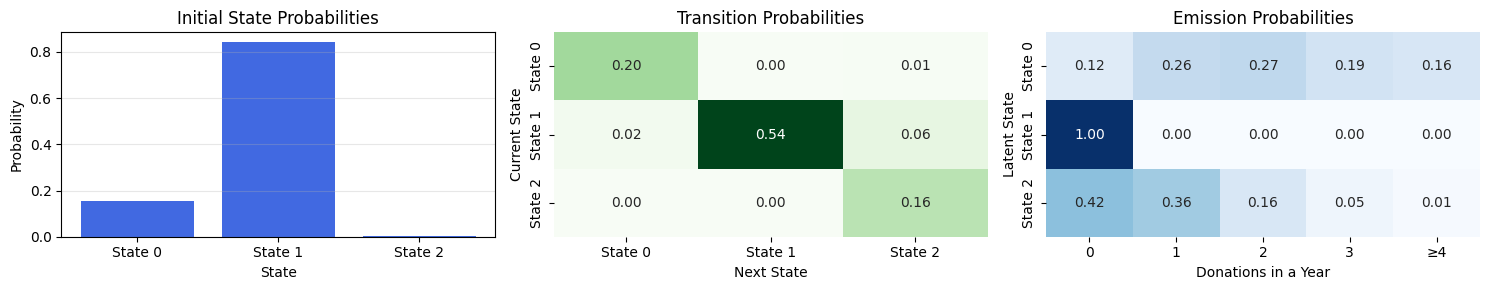

In [277]:
plot_hmm_params(
    transitions=A_norm,
    initial_probs=pi_norm,
    emissions=build_emission_matrix_truncated_poisson(rates_norm, max_k=4),
    emission_names=[str(i) for i in range(4)] + ["≥4"]
)

### Geometric

In this section, we use a Geometric distribution for the emission probabilities instead of a Poisson. Both distributions can model count data, but with different interpretations: the Poisson models the total number of events in a fixed period, while the Geometric models the number of trials until the first success.
However, in our dataset, the observed data are yearly donation counts ranging from 0 to 4. Using a Geometric emission can provide a different latent structure compared to the Poisson, but it is less natural for bounded count data, since the Geometric is unbounded above. This choice mainly affects how the HMM explains the observed counts and the interpretation of the latent states.

In [278]:
import torch
import pyro
import pyro.distributions as dist
from pyro.infer import SVI, TraceEnum_ELBO
from pyro.infer.autoguide import AutoDelta
from pyro.optim import Adam

def model(observations):
    N, T = observations.shape
    num_states = 3

    pi = pyro.sample("pi", dist.Dirichlet(torch.ones(num_states)))
    A = pyro.sample("A", dist.Dirichlet(torch.ones(num_states, num_states)).to_event(1))
    probs = pyro.sample("probs", dist.Beta(2.0 * torch.ones(num_states), torch.ones(num_states)).to_event(1))

    with pyro.plate("donors", N):
        x = pyro.sample("PD_0", dist.Categorical(pi), infer={"enumerate": "parallel"})
        for t in pyro.markov(range(T)):
            x = pyro.sample(f"PD_{t+1}", dist.Categorical(A[x]), infer={"enumerate": "parallel"})
            pyro.sample(f"y_{t}", dist.Geometric(probs[x]), obs=observations[:, t])

def guide(observations):
    num_states = 3
    pi_alpha = pyro.param("pi_alpha", torch.ones(num_states), constraint=dist.constraints.positive)
    A_alpha = pyro.param("A_alpha", torch.ones(num_states, num_states), constraint=dist.constraints.positive)
    probs_alpha = pyro.param("probs_alpha", 2.0 * torch.ones(num_states), constraint=dist.constraints.positive)
    probs_beta = pyro.param("probs_beta", torch.ones(num_states), constraint=dist.constraints.positive)

    pyro.sample("pi", dist.Dirichlet(pi_alpha))
    pyro.sample("A", dist.Dirichlet(A_alpha).to_event(1))
    pyro.sample("probs", dist.Beta(probs_alpha, probs_beta).to_event(1))

pyro.clear_param_store()  # resetta tutti i parametri!

optimizer = Adam({"lr": 0.01})
svi = SVI(model, guide, optimizer, loss=TraceEnum_ELBO(max_plate_nesting=1))

# pyro.render_model(model, model_args=(obs_torch,), render_distributions=False)


for step in range(2_000):
    loss = svi.step(obs_torch)
    if step % 200 == 0:
        print(f"Step {step} loss: {loss}")

Step 0 loss: 194147.796875
Step 200 loss: 178061.5
Step 400 loss: 183703.8125
Step 600 loss: 185803.890625
Step 800 loss: 153785.328125
Step 1000 loss: 170042.9375
Step 1200 loss: 160255.84375
Step 1400 loss: 149352.6875
Step 1600 loss: 149521.4375
Step 1800 loss: 147761.609375


In [279]:
learned_pi = pyro.param("pi_alpha").detach().cpu().numpy()
learned_A = pyro.param("A_alpha").detach().cpu().numpy()
learned_rates_alpha = pyro.param("probs_alpha").detach().cpu().numpy()
learned_rates_beta = pyro.param("probs_beta").detach().cpu().numpy()


pi_norm = learned_pi / learned_pi.sum()
A_norm = learned_A / learned_A.sum()
rates_norm = learned_rates_alpha / learned_rates_beta

print("Initial state probabilities (normalized):", pi_norm)
print("Transition matrix (normalized):", A_norm)
print("Poisson rates:", rates_norm)

Initial state probabilities (normalized): [0.82055163 0.08681605 0.09263234]
Transition matrix (normalized): [[0.3845655  0.02487707 0.03226667]
 [0.00117265 0.2269427  0.00241895]
 [0.001001   0.00150449 0.32525098]]
Poisson rates: [56.52672     0.82996356  0.8316362 ]


Most people start in state 2, which is expected since some individuals begin donating later or were not eligible to donate due to their age. The transition matrix shows that individuals in state 2 tend to move to state 0 or 1. Once they reach state 0 or 1, donors tend to maintain their donation behavior. State 1 appears to be the most populated, likely representing occasional donors, while state 0 can be interpreted as the state of frequent donors.

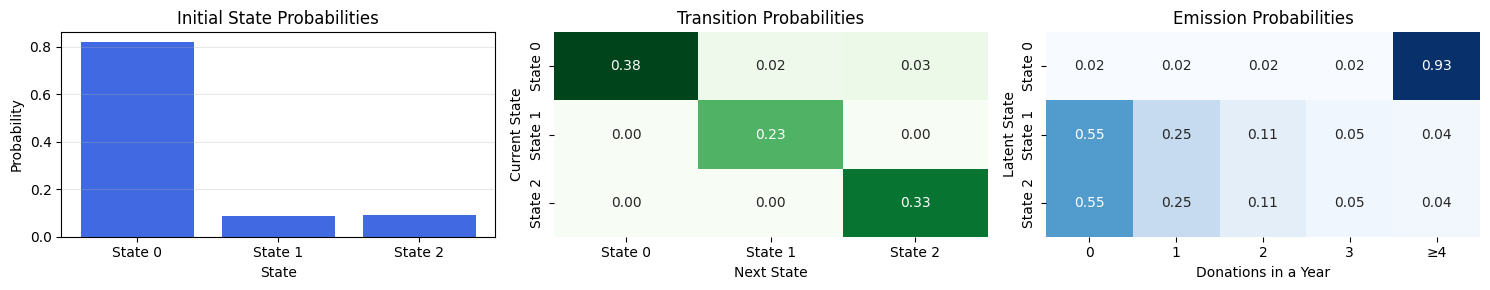

In [280]:
import numpy as np
from scipy.stats import geom

def build_emission_matrix_truncated_geometric(rates, max_k=4):
    S = len(rates)
    K = max_k + 1  # da 0 a 4, 5 valori
    ps = 1 / (rates + 1)
    emissions = np.zeros((S, K))
    for s in range(S):
        # Geometric shiftata: geom.pmf(k+1, p)
        for k in range(max_k):
            emissions[s, k] = geom.pmf(k+1, ps[s])
        # L'ultimo raccoglie tutta la coda: P(y >= max_k)
        emissions[s, max_k] = 1 - geom.cdf(max_k, ps[s])
    return emissions

emissions_matrix = build_emission_matrix_truncated_geometric(rates_norm, max_k=4)

plot_hmm_params(
    transitions=A_norm,
    initial_probs=pi_norm,
    emissions=emissions_matrix,
    emission_names=[str(i) for i in range(4)] + ["≥4"]
)

## Models with covariates

### Mixed Model

This is not any more a HMM but is a mixture model where each units has only one latent variable

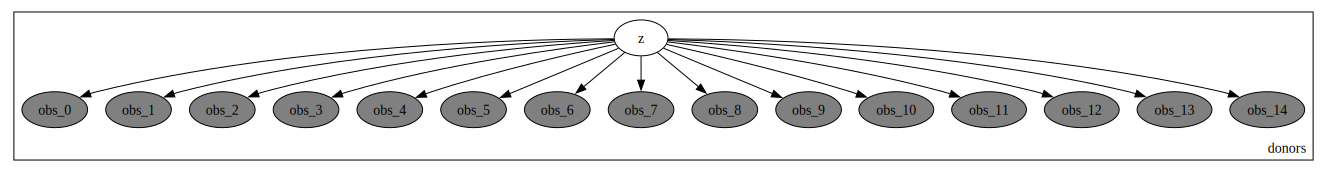

In [23]:
import torch
import pyro
import pyro.distributions as dist
from pyro.nn import PyroSample, PyroModule
import pyro.distributions.constraints as constraints

def model(observations, donors_covariates):
    N, T = observations.shape
    K = 3  # numero di stati latenti
    
    with pyro.plate("latent_params", K):
        rate = pyro.param("rate", torch.ones(K), constraint=constraints.positive)  # emission rate per stato
    
    # Probs statici per gli stati latenti (es: uniforme o funzione delle covariate)
    if donors_covariates is not None:
        C = donors_covariates.shape[2]
        W0 = pyro.param("W0", torch.zeros(K, C))
        logits = torch.matmul(donors_covariates[:, 0, :], W0.T)  # [N, K]
        probs = torch.softmax(logits, dim=-1)
    else:
        probs = torch.ones(N, K) / K

    with pyro.plate("donors", N):
        z = pyro.sample("z", dist.Categorical(probs=probs))  # stato latente per ciascun individuo

        for t in range(T):
            lam = rate[z]  # emission rate Poisson, shape: (N,)
            pyro.sample(f"obs_{t}", dist.Poisson(lam), obs=observations[:, t])

def guide(observations, donors_covariates):
    N, T = observations.shape
    K = 3

    q_logits = pyro.param("q_logits", torch.zeros(N, K))
    with pyro.plate("donors", N):
        pyro.sample("z", dist.Categorical(logits=q_logits))

pyro.render_model(model, model_args=(obs_torch, covariates_torch), render_distributions=False)

In [24]:
from pyro.optim import ClippedAdam
from pyro.infer import SVI, Trace_ELBO
# Assumendo: observations_torch (N, T) e covariates_torch (N, C) siano tensor torch
pyro.clear_param_store()

optimizer = ClippedAdam({"lr": 0.1})
elbo = Trace_ELBO()
svi = SVI(model, guide, optimizer, loss=elbo)

n_steps = 200
for step in range(n_steps):
    loss = svi.step(obs_torch, covariates_torch)
    if step % 20 == 0:
        print(f"[{step}] Loss = {loss:.2f}")


[0] Loss = 177716.08
[20] Loss = 174394.08
[40] Loss = 174802.21
[60] Loss = 174968.35
[80] Loss = 175144.89
[100] Loss = 175203.88
[120] Loss = 175361.34
[140] Loss = 175416.43
[160] Loss = 175551.00
[180] Loss = 175462.03


Probabilità iniziali (media popolazione): [0.32096067 0.34893122 0.33010948]
Rate Poisson per stato: [0.76969683 0.7471207  0.74484223]
Matrice di transizione (identità):
 [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]


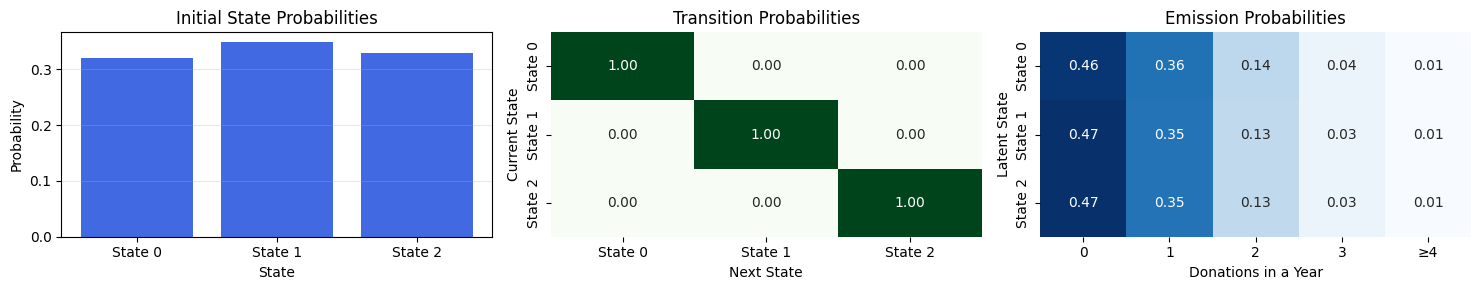

In [25]:
import numpy as np

# Estrai i parametri stimati
rate = pyro.param("rate").detach().cpu().numpy()  # [K]
W0 = pyro.param("W0").detach().cpu().numpy()      # [K, C]

# Calcola le probabilità iniziali medie sulla popolazione
logits = np.matmul(covariates_torch[:, 0, :].cpu().numpy(), W0.T)  # [N, K]
probs = np.exp(logits) / np.exp(logits).sum(axis=1, keepdims=True)
init_probs = probs.mean(axis=0)  # media sulle N persone

# Nessuna matrice di transizione in questo modello, puoi usare una matrice identità o None
transitions = np.eye(rate.shape[0])

# Costruisci la matrice di emissione Poisson come prima
def build_emission_matrix_truncated_poisson(rates, max_k=4):
    from scipy.stats import poisson
    S = len(rates)
    K = max_k + 1
    emissions = np.zeros((S, K))
    for s in range(S):
        for k in range(max_k):
            emissions[s, k] = poisson.pmf(k, rates[s])
        emissions[s, max_k] = 1 - poisson.cdf(max_k-1, rates[s])
    return emissions

emissions_matrix = build_emission_matrix_truncated_poisson(rate, max_k=4)

# Stampa i risultati numerici
print("Probabilità iniziali (media popolazione):", init_probs)
print("Rate Poisson per stato:", rate)
print("Matrice di transizione (identità):\n", transitions)

# Visualizza il grafico
plot_hmm_params(
    transitions=transitions,
    initial_probs=init_probs,
    emissions=emissions_matrix,
    emission_names=[str(i) for i in range(4)] + ["≥4"]
)

### Static Covariates

#### Poisson

In [281]:
def model(observations, donors_covariates):
    N, T = observations.shape
    K = 3
    C = donors_covariates.shape[2]

    # Parametri emissioni
    rate = pyro.param("rate", torch.ones(K), constraint=constraints.positive)
    # Parametri iniziali
    init_logits = pyro.param("init_logits", torch.zeros(K))
    # Parametri transizione
    trans_W = pyro.param("trans_W", torch.zeros(K, K, C))
    trans_b = pyro.param("trans_b", torch.zeros(K, K))

    with pyro.plate("donors", N):
        # Stato iniziale
        z_prev = pyro.sample(
            "z_0", dist.Categorical(logits=init_logits)
        )
        lam = rate[z_prev]
        pyro.sample("obs_0", dist.Poisson(lam), obs=observations[:, 0])

        # vectorized
        for t in range(1, T):
            trans_W_zprev = trans_W[z_prev]           # (N, K, C)
            trans_b_zprev = trans_b[z_prev]           # (N, K)
            covs = donors_covariates[:, t, :]         # (N, C)
            logits = (trans_W_zprev * covs[:, None, :]).sum(-1) + trans_b_zprev  # (N, K)
            z_t = pyro.sample(f"z_{t}", dist.Categorical(logits=logits))
            lam = rate[z_t]
            pyro.sample(f"obs_{t}", dist.Poisson(lam), obs=observations[:, t])
            z_prev = z_t
        
        # nested loop version (commentata perché non necessaria)
        # for t in range(1, T):
        #     logits = []
        #     for i in range(N):
        #         l = trans_b[z_prev[i]] + (trans_W[z_prev[i]] @ donors_covariates[i, t, :])
        #         logits.append(l)
        #     logits = torch.stack(logits)  # (N, K)
        #     z_t = pyro.sample(
        #         f"z_{t}", dist.Categorical(logits=logits)
        #     )
        #     lam = rate[z_t]
        #     pyro.sample(f"obs_{t}", dist.Poisson(lam), obs=observations[:, t])
        #     z_prev = z_t

def guide(observations, donors_covariates):
    # Mean field: lasciamo che Pyro gestisca tutto
    pass

# pyro.render_model(model, model_args=(obs_torch, covariates_torch), render_distributions=False)

In [282]:
pyro.clear_param_store()  # resetta tutti i parametri!
optimizer = Adam({"lr": 0.1})
elbo = TraceEnum_ELBO(max_plate_nesting=1)
svi = SVI(model, guide, optimizer, loss=elbo)
n_steps = 2_000
for step in range(n_steps):
    loss = svi.step(obs_torch, covariates_torch)
    if step % 200 == 0:
        print(f"[{step}] Loss = {loss:.2f}")


c:\Users\erik4\AppData\Local\Programs\Python\Python313\Lib\site-packages\pyro\util.py:303: UserWarning: Found vars in model but not guide: {'z_8', 'z_12', 'z_3', 'z_13', 'z_5', 'z_11', 'z_10', 'z_14', 'z_9', 'z_2', 'z_7', 'z_4', 'z_6', 'z_0', 'z_1'}
  warnings.warn(f"Found vars in model but not guide: {bad_sites}")
c:\Users\erik4\AppData\Local\Programs\Python\Python313\Lib\site-packages\pyro\infer\traceenum_elbo.py:355: UserWarning: TraceEnum_ELBO found no sample sites configured for enumeration. If you want to enumerate sites, you need to @config_enumerate or set infer={"enumerate": "sequential"} or infer={"enumerate": "parallel"}? If you do not want to enumerate, consider using Trace_ELBO instead.
  warnings.warn(


[0] Loss = 329916.78
[200] Loss = 231231.50
[400] Loss = 189944.92
[600] Loss = 177639.22
[800] Loss = 174965.50
[1000] Loss = 177652.25
[1200] Loss = 172097.67
[1400] Loss = 173435.81
[1600] Loss = 178462.36
[1800] Loss = 177065.47


Probabilità iniziali (media popolazione): [4.8815942e-05 1.7396404e-05 9.9993384e-01]
Rate Poisson per stato: [0.6587741  1.0408008  0.91448146]
Matrice di transizione (media sulle covariate):
 [[9.91587043e-01 7.80505966e-03 6.07818074e-04]
 [2.42624402e-01 3.07960971e-03 7.54296005e-01]
 [3.86310043e-04 6.85173180e-03 9.92761970e-01]]


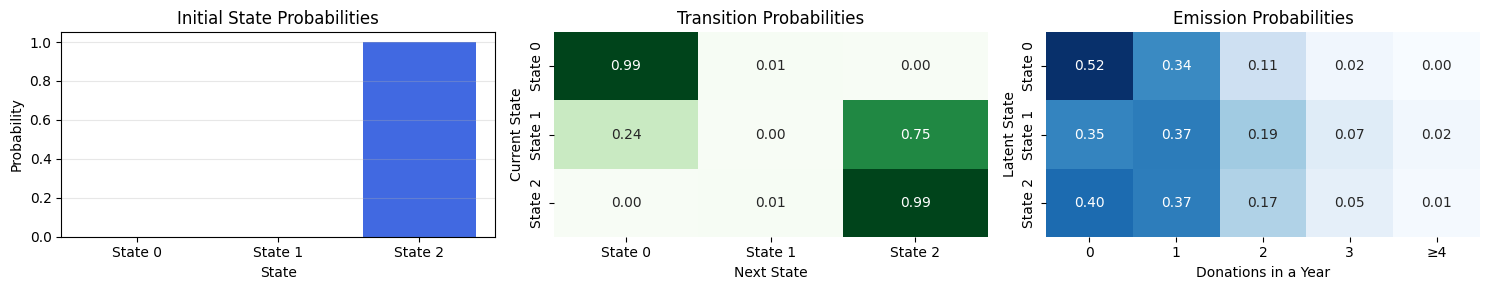

In [283]:
rate = pyro.param("rate").detach().cpu().numpy()  # [K]

K, C = pyro.param("trans_W").shape[-2:]
trans_W = pyro.param("trans_W").detach().cpu().numpy()  # [K, K, C]
trans_b = pyro.param("trans_b").detach().cpu().numpy()  # [K, K]
covs = covariates_torch.cpu().numpy()                   # [N, T, C]

covs_mean = covs[:, 0, :].mean(axis=0)  # [C]

transitions = np.zeros((K, K))
for prev in range(K):
    logits = trans_b[prev] + trans_W[prev] @ covs_mean  # [K]
    probs = np.exp(logits) / np.exp(logits).sum()
    transitions[prev, :] = probs

emissions_matrix = build_emission_matrix_truncated_poisson(rate, max_k=4)

print("Probabilità iniziali (media popolazione):", init_probs)
print("Rate Poisson per stato:", rate)
print("Matrice di transizione (media sulle covariate):\n", transitions)


plot_hmm_params(
    transitions=transitions,
    initial_probs=init_probs,
    emissions=emissions_matrix,
    emission_names=[str(i) for i in range(4)] + ["≥4"]
)

#### Negative Binomial

In [284]:
import torch
import pyro
import pyro.distributions as dist
import pyro.distributions.constraints as constraints
from pyro.infer import config_enumerate

@config_enumerate
def model(observations, donors_covariates):
    N, T = observations.shape
    K = 3
    C = donors_covariates.shape[2]

    # Parametri emissioni per stato: total_count e prob
    total_count = pyro.param("total_count", torch.ones(K), constraint=constraints.positive)
    logits = pyro.param("emiss_logits", torch.zeros(K))  # per la prob: prob = sigmoid(logits)

    # Parametri iniziali
    init_logits = pyro.param("init_logits", torch.zeros(K))
    # Parametri transizione
    trans_W = pyro.param("trans_W", torch.zeros(K, K, C))
    trans_b = pyro.param("trans_b", torch.zeros(K, K))

    with pyro.plate("donors", N):
        # Stato iniziale
        z_prev = pyro.sample(
            "z_0", dist.Categorical(logits=init_logits)
        )
        # Emissione iniziale: NB
        nb_total = total_count[z_prev]
        nb_prob = torch.sigmoid(logits[z_prev])
        pyro.sample("obs_0", dist.NegativeBinomial(total_count=nb_total, probs=nb_prob), obs=observations[:, 0])

        for t in range(1, T):
            trans_W_zprev = trans_W[z_prev]           # (N, K, C)
            trans_b_zprev = trans_b[z_prev]           # (N, K)
            covs = donors_covariates[:, t, :]         # (N, C)
            trans_logits = (trans_W_zprev * covs[:, None, :]).sum(-1) + trans_b_zprev  # (N, K)
            z_t = pyro.sample(f"z_{t}", dist.Categorical(logits=trans_logits))
            # Emissione Negative Binomial
            nb_total = total_count[z_t]
            nb_prob = torch.sigmoid(logits[z_t])
            pyro.sample(f"obs_{t}", dist.NegativeBinomial(total_count=nb_total, probs=nb_prob), obs=observations[:, t])
            z_prev = z_t

@config_enumerate
def guide(observations, donors_covariates):
    # Mean field: lasciamo che Pyro gestisca tutto
    pass

In [285]:
pyro.clear_param_store()
optimizer = Adam({"lr": 0.1})
elbo = TraceEnum_ELBO(max_plate_nesting=1)
svi = SVI(model, guide, optimizer, loss=elbo)
n_steps = 2_000
for step in range(n_steps):
    loss = svi.step(obs_torch, covariates_torch)
    if step % 200 == 0:
        print(f"[{step}] Loss = {loss:.2f}")


[0] Loss = 169450.20
[200] Loss = 125910.77
[400] Loss = 125643.09
[600] Loss = 125493.02
[800] Loss = 125442.97
[1000] Loss = 125422.36
[1200] Loss = 125421.87
[1400] Loss = 125421.13
[1600] Loss = 125368.32
[1800] Loss = 125419.61


In [286]:
# Recupera i valori ottimizzati
total_count = pyro.param("total_count").detach().cpu().numpy()   # shape (K,)
emiss_logits = pyro.param("emiss_logits").detach().cpu().numpy() # shape (K,)
probs = 1 / (1 + np.exp(-emiss_logits))  # sigmoid

print("Rate Negative Binomial per stato:")
for k in range(len(total_count)):
    print(f"  Stato {k}: total_count = {total_count[k]:.3f}, prob = {probs[k]:.3f}")

Rate Negative Binomial per stato:
  Stato 0: total_count = 0.039, prob = 0.059
  Stato 1: total_count = 3749.990, prob = 0.001
  Stato 2: total_count = 1834.141, prob = 0.000


In [287]:
means = total_count * (1 - probs) / probs
print("Media Negative Binomial per stato:")
for k in range(len(total_count)):
    print(f"  Stato {k}: mean = {means[k]:.3f}")

Media Negative Binomial per stato:
  Stato 0: mean = 0.623
  Stato 1: mean = 6611195.500
  Stato 2: mean = 3823883.000


Probabilità iniziali (media popolazione): [0.6954472  0.19351782 0.11103499]
Negative Binomial total_count per stato: [3.8824789e-02 3.7499897e+03 1.8341406e+03]
Negative Binomial probs per stato: [0.05867725 0.0005669  0.00047942]
Matrice di transizione (media sulle covariate):
 [[9.89976883e-01 7.44124083e-03 2.58185528e-03]
 [7.39457537e-05 8.35099280e-01 1.64826781e-01]
 [1.91359803e-01 1.06825682e-04 8.08533370e-01]]


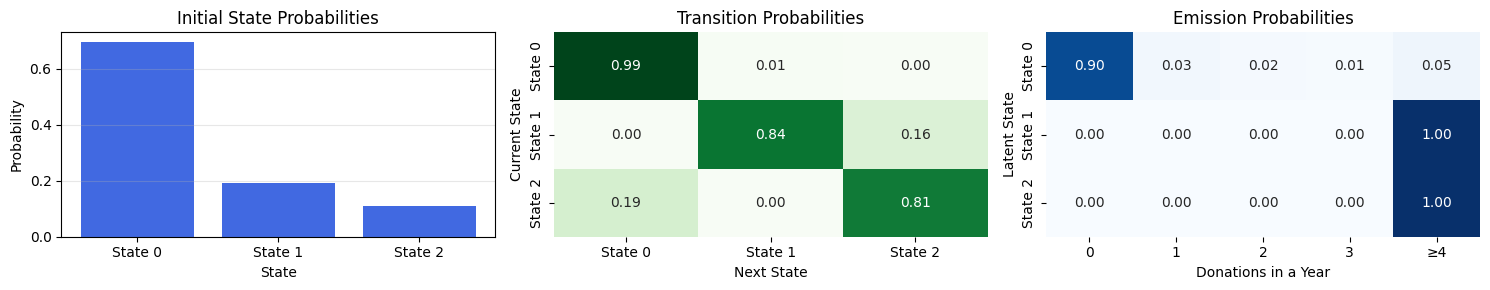

In [288]:
import numpy as np

# 1. Estrai i parametri stimati
total_count = pyro.param("total_count").detach().cpu().numpy()    # [K]
emiss_logits = pyro.param("emiss_logits").detach().cpu().numpy()  # [K]
probs = 1 / (1 + np.exp(-emiss_logits))                          # [K]

# for dependency with init_W and init_b
# init_W = pyro.param("init_W").detach().cpu().numpy()  # [K, C]
# init_b = pyro.param("init_b").detach().cpu().numpy()  # [K]
# covs_0 = covariates_torch[:, 0, :].cpu().numpy()      # [N, C]
# logits = covs_0 @ init_W.T + init_b                   # [N, K]
# probs_init = np.exp(logits) / np.exp(logits).sum(axis=1, keepdims=True)  # [N, K]
# init_probs = probs_init.mean(axis=0)                  # [K]

# Only inital logits
init_logits = pyro.param("init_logits").detach().cpu().numpy()  # [K]
init_probs = np.exp(init_logits) / np.exp(init_logits).sum()    # [K]

K, C = pyro.param("trans_W").shape[-2:]
trans_W = pyro.param("trans_W").detach().cpu().numpy()  # [K, K, C]
trans_b = pyro.param("trans_b").detach().cpu().numpy()  # [K, K]
covs = covariates_torch.cpu().numpy()                   # [N, T, C]

# Media sulle covariate del primo anno
covs_mean = covs[:, 0, :].mean(axis=0)  # [C]

# Matrice di transizione media per ogni stato
transitions = np.zeros((K, K))
for prev in range(K):
    logits = trans_b[prev] + trans_W[prev] @ covs_mean  # [K]
    probs_tr = np.exp(logits) / np.exp(logits).sum()
    transitions[prev, :] = probs_tr

# Costruisci la matrice di emissione Negative Binomial (truncated)
def build_emission_matrix_truncated_nbinom(total_count, probs, max_k=4):
    from scipy.stats import nbinom
    S = len(total_count)
    K = max_k + 1
    emissions = np.zeros((S, K))
    for s in range(S):
        for k in range(max_k):
            emissions[s, k] = nbinom.pmf(k, total_count[s], probs[s])
        emissions[s, max_k] = 1 - nbinom.cdf(max_k-1, total_count[s], probs[s])
    return emissions

emissions_matrix = build_emission_matrix_truncated_nbinom(total_count, probs, max_k=4)

# Stampa i risultati numerici
print("Probabilità iniziali (media popolazione):", init_probs)
print("Negative Binomial total_count per stato:", total_count)
print("Negative Binomial probs per stato:", probs)
print("Matrice di transizione (media sulle covariate):\n", transitions)

plot_hmm_params(
    transitions=transitions,
    initial_probs=init_probs,
    emissions=emissions_matrix,
    emission_names=[str(i) for i in range(4)] + ["≥4"]
)

In [289]:
import pandas as pd
rows = []
for i in range(K):
    for j in range(K):
        for c, name in enumerate(['birth_year_norm', 'gender_code']):
            rows.append({'from': i, 'to': j, 'covariate': name, 'weight': trans_W[i,j,c]})
df = pd.DataFrame(rows)
print(df.pivot_table(index=['from', 'to'], columns='covariate', values='weight'))

covariate  birth_year_norm  gender_code
from to                                
0    0           -1.888717     1.209506
     1           -0.115474    -1.712031
     2            4.572589     1.480289
1    0           -1.273658     0.616180
     1            1.255628    -0.334373
     2            0.849289     1.748105
2    0           -1.297942     1.859083
     1            0.122509    -1.968980
     2            2.129316     2.189386


### Dynamic Covariates

#### Negative Binomial

In [293]:
import pyro
from pyro.optim import Adam
from pyro.infer import SVI, TraceEnum_ELBO

pyro.clear_param_store()
optimizer = Adam({"lr": 0.1, "weight_decay": 0.1})
elbo = TraceEnum_ELBO(max_plate_nesting=1)
svi = SVI(model, guide, optimizer, loss=elbo)

num_steps = 2_000
for step in range(num_steps):
    loss = svi.step(obs_torch, full_cov_torch)
    # Aggiungi la penalità soft alle emissioni, dopo ogni step
    # penalty = emission_penalty(weight=10.0)
    penalty = total_penalty()
    total_loss = loss + penalty.item()
    if step % (num_steps // 10) == 0:
        print(f"Step {step} : loss = {loss:.2f} (penalty: {penalty.item():.2f})  tot: {total_loss:.2f}")

Step 0 : loss = 254705.47 (penalty: 6.19)  tot: 254711.66


KeyboardInterrupt: 

In [202]:
# ────────────────────────────────────────────────────────────────
#  HMM a stati discreti con emissioni Negative Binomial,
#  rivisto per far sì che lo STATE 0 sia visitato più spesso
# ────────────────────────────────────────────────────────────────
import torch, pyro
# from pyro import constraints
from pyro.infer import config_enumerate, SVI, TraceEnum_ELBO
from pyro.optim import Adam
import pyro.distributions as dist

K = 3                                # numero stati nascosti
# ---------- TARGET (usate per “penalties” o come vere prior) ----
#   Stato 0 ora ha mean ≈ 0.5 invece di 0.01
target_total_count = torch.tensor([2.0, 1.5, 1.5])
target_probs       = torch.tensor([0.80, 0.50, 0.30])

target_init_probs  = torch.tensor([0.60, 0.20, 0.20])
target_trans_probs = torch.tensor([[0.70, 0.15, 0.15],
                                   [0.25, 0.50, 0.25],
                                   [0.25, 0.25, 0.50]])

# ---------- PARAM INIT ---------------------------------------------------------
init_total_count = target_total_count.clone()
init_logits      = torch.logit(target_probs.clone())   # emiss logits

# ───────────────────────────────────────────────── MODEL ────────────────────────
@config_enumerate
def model(observations, donors_covariates):
    N, T = observations.shape
    C    = donors_covariates.shape[2]

    # PARAMETRI LEARNABLE (usiamo pyro.param)
    total_count = pyro.param("total_count",
                             init_total_count.clone(),
                             constraint=constraints.positive)
    emiss_logits = pyro.param("emiss_logits",
                              init_logits.clone())            # shape (K,)

    init_logits_param = pyro.param("init_logits", torch.zeros(K))
    trans_W  = pyro.param("trans_W", torch.zeros(K, K, C))
    trans_b  = pyro.param("trans_b", torch.zeros(K, K))

    # ------------------ modello generativo -------------------------------------
    with pyro.plate("donors", N):
        z_prev = pyro.sample("z_0",
                             dist.Categorical(logits=init_logits_param),
                             infer={"enumerate": "parallel"})

        nb_total = total_count[z_prev]
        nb_prob  = torch.sigmoid(emiss_logits[z_prev])
        pyro.sample("obs_0",
                    dist.NegativeBinomial(total_count=nb_total, probs=nb_prob),
                    obs=observations[:, 0])

        for t in range(1, T):
            cov_t = donors_covariates[:, t, :]                # (N, C)
            trans_logits = (trans_W[z_prev] * cov_t[:, None, :]).sum(-1) + trans_b[z_prev]
            z_t = pyro.sample(f"z_{t}",
                              dist.Categorical(logits=trans_logits),
                              infer={"enumerate": "parallel"})

            nb_total = total_count[z_t]
            nb_prob  = torch.sigmoid(emiss_logits[z_t])
            pyro.sample(f"obs_{t}",
                        dist.NegativeBinomial(total_count=nb_total, probs=nb_prob),
                        obs=observations[:, t])
            z_prev = z_t

    # --------------- soft-constraint via penalty ------------------------------
    pyro.factor("all_penalties", -total_penalty())

# ────────────────────────────────────────── GUIDE ──────────────────────────────
def guide(observations, donors_covariates):
    N, T = observations.shape
    C    = donors_covariates.shape[2]

    trans_W_q = pyro.param("trans_W_q", torch.zeros(K, K, C))
    trans_b_q = pyro.param("trans_b_q", torch.zeros(K, K))
    init_logits_q = pyro.param("init_logits_q", torch.zeros(K))

    with pyro.plate("donors", N):
        z_prev = pyro.sample("z_0", dist.Categorical(logits=init_logits_q))
        for t in range(1, T):
            cov_t      = donors_covariates[:, t, :]
            logits_q   = (trans_W_q[z_prev] * cov_t[:, None, :]).sum(-1) + trans_b_q[z_prev]
            z_prev     = pyro.sample(f"z_{t}", dist.Categorical(logits=logits_q))

# ─────────────────────────────── PENALTIES (riviste) ───────────────────────────
def emission_penalty():
    w = torch.tensor([200.0, 10.0, 40.0])          # ↑↑ stato 0, un po’ stato 2
    tot   = pyro.param("total_count")
    prob  = torch.sigmoid(pyro.param("emiss_logits"))
    return ((w*(tot  - target_total_count)**2).sum() +
            (w*(prob - target_probs)      **2).sum())

def initial_state_penalty():
    init_p = torch.softmax(pyro.param("init_logits"), -1)
    return 200.0*((init_p - target_init_probs)**2).sum()

def transition_penalty():
    trans_p = torch.softmax(pyro.param("trans_b"), -1)
    W = torch.tensor([[200.,  40.,  40.],          # riga 0 → voglio diag alta
                      [ 20.,  10.,  20.],
                      [ 20.,  20.,  10.]])
    return ((W*(trans_p - target_trans_probs)**2)).sum()

def total_penalty():
    return (emission_penalty() +
            initial_state_penalty() +
            transition_penalty())

# ───────────────────────────────────── TRAINING LOOP ───────────────────────────
pyro.clear_param_store()
optimizer = Adam({"lr": 0.05, "weight_decay": 0.0})      # meno weight-decay
elbo      = TraceEnum_ELBO(max_plate_nesting=1)
svi       = SVI(model, guide, optimizer, loss=elbo)

num_steps = 10_000
for step in range(num_steps):
    loss    = svi.step(obs_torch, full_cov_torch)
    penalty = total_penalty().item()
    if step % (num_steps // 10) == 0:
        print(f"step {step:3d} | ELBO {loss:,.0f} | penalty {penalty:6.2f} | total {loss+penalty:,.0f}")

c:\Users\erik4\AppData\Local\Programs\Python\Python313\Lib\site-packages\pyro\infer\traceenum_elbo.py:355: UserWarning: TraceEnum_ELBO found no sample sites configured for enumeration. If you want to enumerate sites, you need to @config_enumerate or set infer={"enumerate": "sequential"} or infer={"enumerate": "parallel"}? If you do not want to enumerate, consider using Trace_ELBO instead.
  warnings.warn(


step   0 | ELBO 255,117 | penalty  49.13 | total 255,166
step 1000 | ELBO 154,188 | penalty 434.02 | total 154,622
step 2000 | ELBO 153,938 | penalty 426.96 | total 154,365
step 3000 | ELBO 154,026 | penalty 536.21 | total 154,562
step 4000 | ELBO 153,760 | penalty 518.91 | total 154,279
step 5000 | ELBO 153,514 | penalty 514.53 | total 154,029
step 6000 | ELBO 153,542 | penalty 499.74 | total 154,042
step 7000 | ELBO 153,467 | penalty 504.98 | total 153,972
step 8000 | ELBO 153,511 | penalty 503.17 | total 154,014
step 9000 | ELBO 153,325 | penalty 514.27 | total 153,839


In [10]:
pyro.render_model()

TypeError: render_model() missing 1 required positional argument: 'model'

Rate Negative Binomial per stato:
  Stato 0: total_count = 2.692, prob = 0.311
  Stato 1: total_count = 4.623, prob = 0.146
  Stato 2: total_count = 0.259, prob = 0.550
Probabilità iniziali (media popolazione): [4.8212166e-07 5.0176158e-07 9.9999899e-01]
Negative Binomial total_count per stato: [2.6917922  4.6227984  0.25854412]
Negative Binomial probs per stato: [0.31108946 0.1458188  0.5502499 ]
Matrice di transizione (media sulle covariate):
 [[9.99935746e-01 4.49117433e-05 1.93761316e-05]
 [9.19607373e-06 9.99972045e-01 1.87793048e-05]
 [1.20629906e-07 8.36663673e-07 9.99999046e-01]]


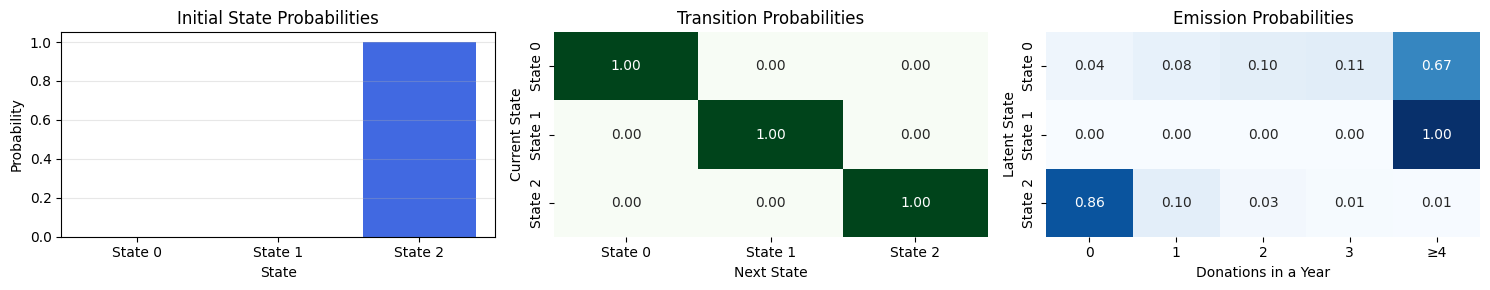

In [203]:
import numpy as np

# Recupera i valori ottimizzati
total_count = pyro.param("total_count").detach().cpu().numpy()   # shape (K,)
emiss_logits = pyro.param("emiss_logits").detach().cpu().numpy() # shape (K,)
probs = 1 / (1 + np.exp(-emiss_logits))  # sigmoid

print("Rate Negative Binomial per stato:")
for k in range(len(total_count)):
    print(f"  Stato {k}: total_count = {total_count[k]:.3f}, prob = {probs[k]:.3f}")
init_logits = pyro.param("init_logits").detach().cpu().numpy()  # [K]
init_probs = np.exp(init_logits) / np.exp(init_logits).sum()    # [K]

K, C = pyro.param("trans_W").shape[-2:]
trans_W = pyro.param("trans_W").detach().cpu().numpy()  # [K, K, C]
trans_b = pyro.param("trans_b").detach().cpu().numpy()  # [K, K]
covs = full_cov_torch.cpu().numpy()                   # [N, T, C]

# Media sulle covariate del primo anno
covs_mean = covs[:, 0, :].mean(axis=0)  # [C]

# Matrice di transizione media per ogni stato
transitions = np.zeros((K, K))
for prev in range(K):
    logits = trans_b[prev] + trans_W[prev] @ covs_mean  # [K]
    probs_tr = np.exp(logits) / np.exp(logits).sum()
    transitions[prev, :] = probs_tr

# Costruisci la matrice di emissione Negative Binomial (truncated)
def build_emission_matrix_truncated_nbinom(total_count, probs, max_k=4):
    from scipy.stats import nbinom
    S = len(total_count)
    K = max_k + 1
    emissions = np.zeros((S, K))
    for s in range(S):
        for k in range(max_k):
            emissions[s, k] = nbinom.pmf(k, total_count[s], probs[s])
        emissions[s, max_k] = 1 - nbinom.cdf(max_k-1, total_count[s], probs[s])
    return emissions

emissions_matrix = build_emission_matrix_truncated_nbinom(total_count, probs, max_k=4)

# Stampa i risultati numerici
print("Probabilità iniziali (media popolazione):", init_probs)
print("Negative Binomial total_count per stato:", total_count)
print("Negative Binomial probs per stato:", probs)
print("Matrice di transizione (media sulle covariate):\n", transitions)
# with torch.no_grad():
#     probs = [torch.softmax(pyro.param("init_logits"), -1)]
#     P = torch.softmax(pyro.param("trans_b"), -1)
#     print("Init-probs:", probs)
#     print("Transizione:\n", P.cpu().numpy())

plot_hmm_params(
    transitions=transitions,
    initial_probs=init_probs,
    emissions=emissions_matrix,
    emission_names=[str(i) for i in range(4)] + ["≥4"]
)

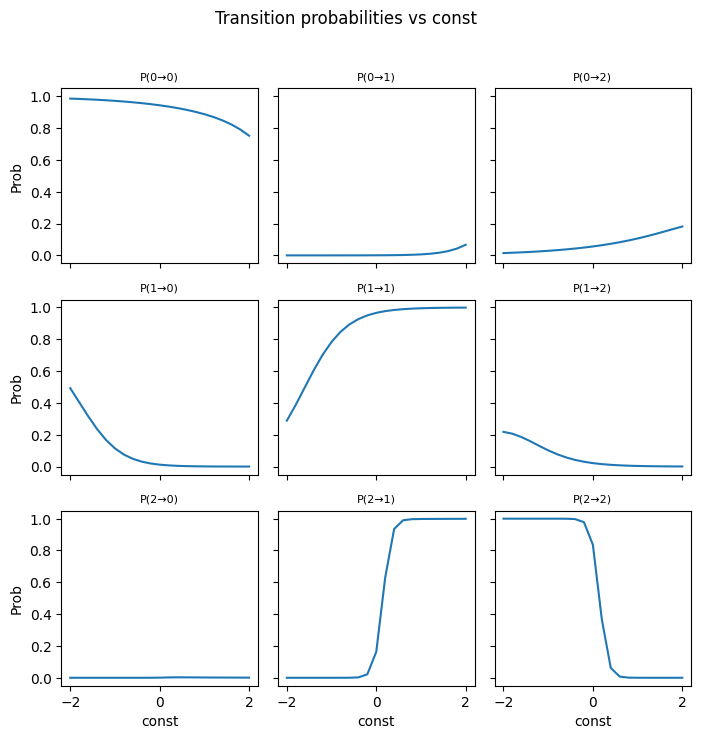

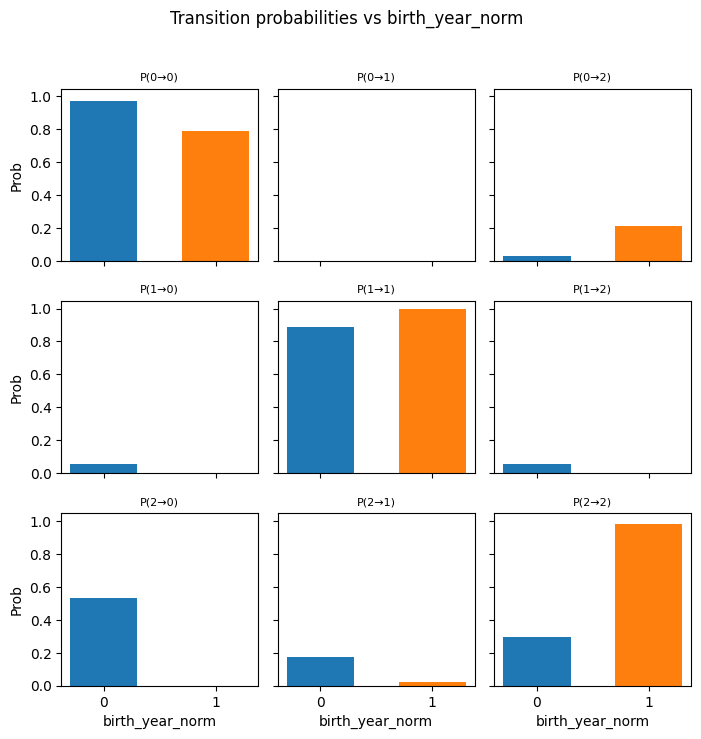

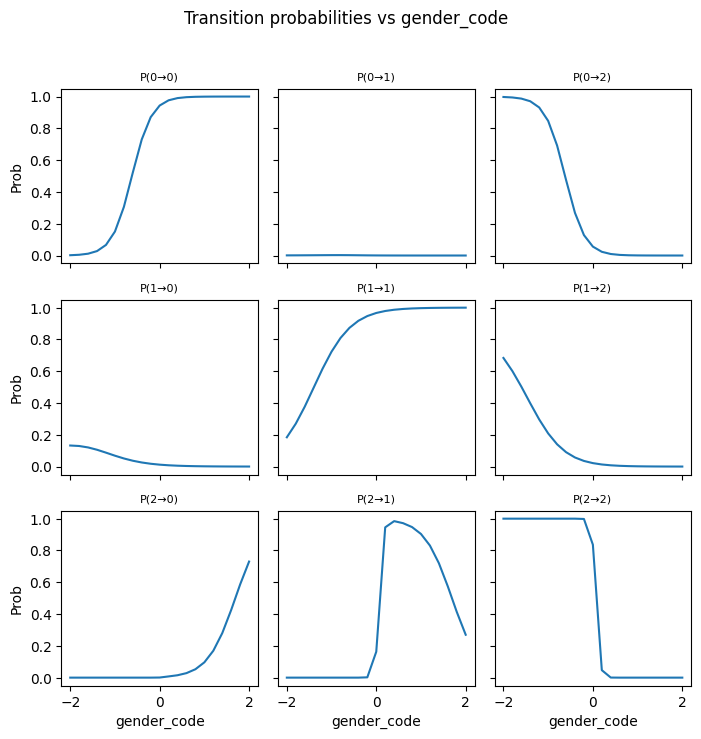

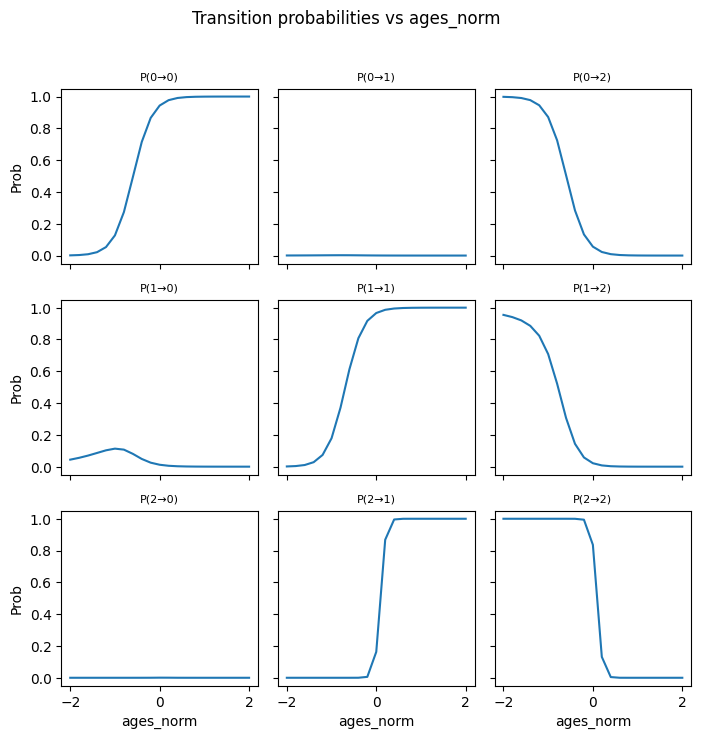

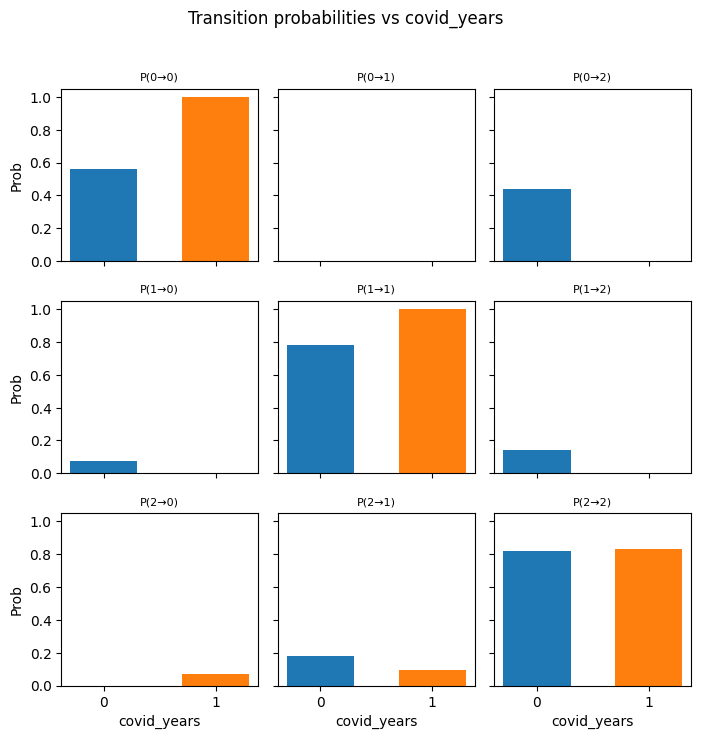

In [211]:
import numpy as np
import matplotlib.pyplot as plt

def plot_transition_grid(var_name, covariate_names,
                         trans_b, trans_W, full_covariates,
                         grid_vals=None):
    """
    Draws K×K small multiples of transition probabilities versus a covariate.

    • If the covariate has ≤2 distinct values -> bar plot (one bar per value).  
    • Otherwise -> line plot on grid_vals (default linspace(-2, 2, 21)).
    """
    K   = trans_b.shape[0]
    idx = covariate_names.index(var_name)

    # ------------------------------------------------------------------
    # Choose values at which to evaluate the covariate
    # ------------------------------------------------------------------
    if grid_vals is None:
        unique_vals = np.unique(full_covariates[..., idx])

        # Treat as categorical when two or fewer distinct values exist
        if len(unique_vals) <= 2:
            grid_vals = unique_vals.astype(float)
            plot_mode = "bar"
        else:
            grid_vals = np.linspace(-2, 2, 21)
            plot_mode = "line"
    else:
        plot_mode = "line"

    # ------------------------------------------------------------------
    # Build transition matrices for each value in grid_vals
    # ------------------------------------------------------------------
    covs_mean = full_covariates.mean(axis=(0, 1))      # Shape [C]
    matrices  = []                                     # Will become (G, K, K)

    for v in grid_vals:
        x = covs_mean.copy()
        x[idx] = v
        P = []
        for prev in range(K):
            logits = trans_b[prev] + trans_W[prev] @ x
            probs  = np.exp(logits) / np.exp(logits).sum()
            P.append(probs)
        matrices.append(np.vstack(P))

    matrices = np.stack(matrices)  # Shape (G, K, K)

    # ------------------------------------------------------------------
    # Plotting
    # ------------------------------------------------------------------
    fig, axes = plt.subplots(K, K, figsize=(K*2.4, K*2.4),
                             sharex=True, sharey=True)

    for i in range(K):
        for j in range(K):
            ax = axes[i, j]
            if plot_mode == "line":
                ax.plot(grid_vals, matrices[:, i, j])
            else:  # bar plot
                bar_width = 0.6
                ax.bar(grid_vals, matrices[:, i, j],
                       width=bar_width, color=['#1f77b4', '#ff7f0e'])
                ax.set_xticks(grid_vals)

            ax.set_title(f"P({i}→{j})", fontsize=8)
            if i == K - 1:
                ax.set_xlabel(var_name)
            if j == 0:
                ax.set_ylabel("Prob")

    plt.suptitle(f"Transition probabilities vs {var_name}", y=1.02)
    plt.tight_layout()
    plt.show()


# ------------------------------------------------------------------
# Call the function for every covariate in the CORRECT order
# ------------------------------------------------------------------
cov_names = [
    "const",
    "birth_year_norm",  # 0 continuous
             "gender_code",      # 1 binary
             "ages_norm",        # 2 continuous
             "covid_years"]      # 3 binary

for name in cov_names:
    plot_transition_grid(name, cov_names,
                         trans_b, trans_W, full_covariates)

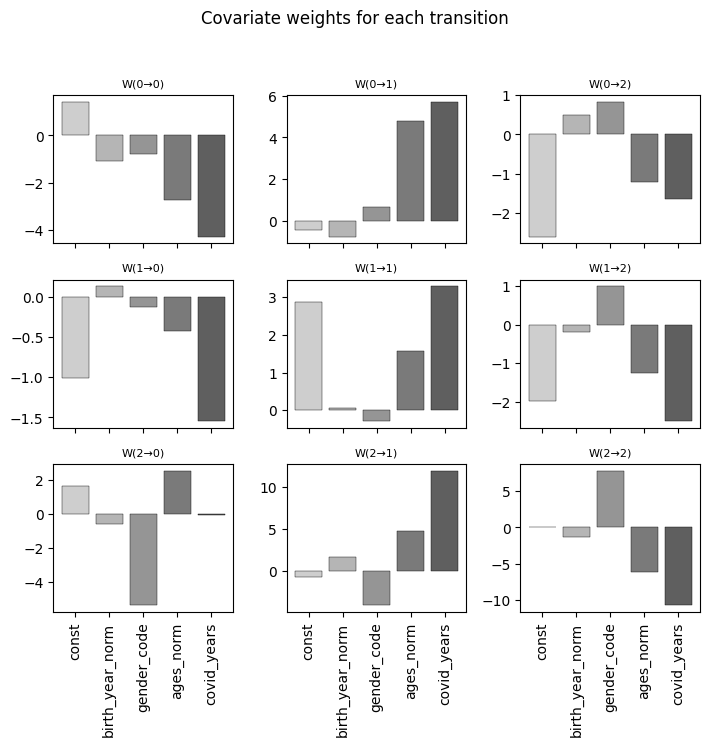

In [251]:
import matplotlib.pyplot as plt
import numpy as np


def plot_weights_grid(
        trans_W,
        covariate_names,
        *,
        const_first=False,
        skip_const=False
):
    """
    Plot a K×K grid of barplots for the weight tensor `trans_W`
    using neutral grey colours and no seaborn.

    Parameters
    ----------
    trans_W : ndarray, shape (K, K, C)
    covariate_names : list[str]  length = C
    const_first : bool, default False
        If True, the column named 'const' is plotted first.
    skip_const : bool, default False
        If True, the column named 'const' is removed from the plot.
    """
    # --------------------------------------------------------------
    # basic checks
    # --------------------------------------------------------------
    if trans_W.shape[2] != len(covariate_names):
        raise ValueError("`trans_W` and `covariate_names` length mismatch")

    idx = list(range(len(covariate_names)))           # [0, 1, …, C-1]

    # --------------------------------------------------------------
    # handle constant column
    # --------------------------------------------------------------
    if "const" in covariate_names:
        const_idx = covariate_names.index("const")

        if skip_const:
            idx.remove(const_idx)                     # drop it
        elif const_first:
            idx = [const_idx] + [i for i in idx if i != const_idx]

    # --------------------------------------------------------------
    # reorder data for plotting only
    # --------------------------------------------------------------
    names_plot = [covariate_names[i] for i in idx]
    W_plot     = trans_W[..., idx]                    # shape (K, K, C_plot)

    K, _, C_plot = W_plot.shape

    # --------------------------------------------------------------
    # pick neutral colours (light → dark grey)
    # --------------------------------------------------------------
    greys = plt.cm.Greys(np.linspace(0.3, 0.7, C_plot))

    # --------------------------------------------------------------
    # plotting
    # --------------------------------------------------------------
    fig, axes = plt.subplots(K, K, figsize=(K * 2.4, K * 2.4), sharex=True)

    for i in range(K):
        for j in range(K):
            ax = axes[i, j]
            ax.bar(
                x=np.arange(C_plot),
                height=W_plot[i, j],
                color=greys,
                edgecolor='black',
                linewidth=0.3
            )
            ax.set_title(f"W({i}→{j})", fontsize=8)
            ax.set_xticks(np.arange(C_plot))
            if i == K - 1:
                ax.set_xticklabels(names_plot, rotation=90)
            else:
                ax.set_xticklabels([])

    plt.suptitle("Covariate weights for each transition", y=1.03)
    plt.tight_layout()
    plt.show()


# --------------------------------------------------------------
# example call
# --------------------------------------------------------------
cov_names = ["birth_year_norm",    # 0
             "gender_code",        # 1
             "ages_norm",          # 2
             "covid_years",        # 3
             "const"]              # 4

plot_weights_grid(trans_W, cov_names, const_first=True, skip_const=False)

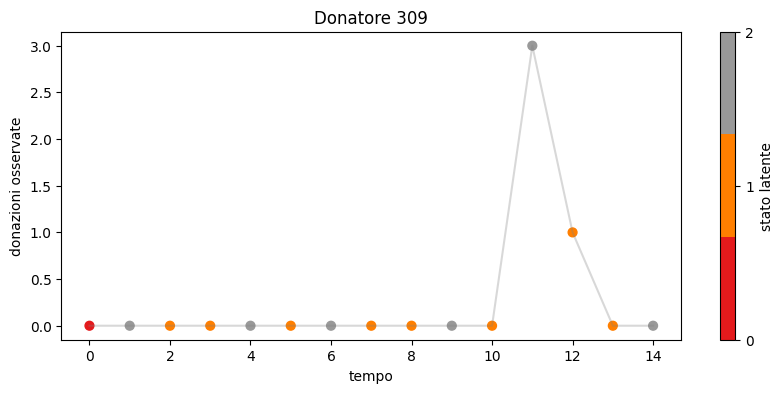

In [250]:
import numpy as np
import matplotlib.pyplot as plt
import torch, pyro, pyro.distributions as dist

def infer_one_path(donor_idx, T):
    """Restituisce una sequenza z_t per un donatore specifico."""
    zs = []
    z = dist.Categorical(logits=pyro.param("init_logits_q")).sample()
    zs.append(z)
    for t in range(1, T):
        cov_t = full_cov_torch[donor_idx, t]
        logits = (pyro.param("trans_W_q")[z] * cov_t).sum(-1) \
                 + pyro.param("trans_b_q")[z]
        z = dist.Categorical(logits=logits).sample()
        zs.append(z)
    return torch.stack(zs)         # shape (T,)

def plot_donor(idx=0):
    x = obs_torch[idx].cpu().numpy()
    T = x.shape[0]

    z_path = infer_one_path(idx, T).cpu().numpy()  # (T,)
    cmap   = plt.get_cmap('Set1', K)

    plt.figure(figsize=(10,4))
    plt.scatter(np.arange(T), x, c=z_path, cmap=cmap, s=40)
    plt.plot(np.arange(T), x, color='grey', alpha=.3)
    plt.colorbar(ticks=range(K), label='stato latente')
    plt.xlabel("tempo")
    plt.ylabel("donazioni osservate")
    plt.title(f"Donatore {idx}")
    plt.show()

plot_donor(309)

In [207]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize

# ------------------------------- utilità colore testo ----------
def _text_color(rgb, thresh=0.45):
    r, g, b = rgb[:3]
    lum = 0.2126*r + 0.7152*g + 0.0722*b
    return 'black' if lum > thresh else 'white'

# ------------------------------- heat-map -----------------------
def plot_state_time_heat(Z, X, years=None, start_year=2009):
    """
    Heat-map: media donazioni per stato latente (Y) e tempo (X).

    Z : ndarray (N, T)   – stati latenti
    X : ndarray (N, T)   – donazioni
    years : array-like o None
        Etichette sull’asse X. Se None vengono generate come
        start_year, start_year+1, …  (lunghezza = T).
    start_year : int
        Usato solo se years è None
    """
    K   = int(Z.max() + 1)
    T   = Z.shape[1]
    yrs = np.arange(start_year, start_year + T) if years is None else np.asarray(years)
    assert len(yrs) == T, "years length mismatch with data shape"

    # media donazioni in ogni (k,t)
    M = np.full((K, T), np.nan)
    for k in range(K):
        for t in range(T):
            sel = Z[:, t] == k
            if sel.any():
                M[k, t] = X[sel, t].mean()

    fig, ax = plt.subplots(figsize=(T*0.55, K*0.60))
    cmap = plt.cm.Reds
    norm = Normalize(vmin=np.nanmin(M), vmax=np.nanmax(M))
    im   = ax.imshow(M, aspect='auto', origin='lower',
                     cmap=cmap, norm=norm, interpolation='nearest')

    # annotazioni
    for k in range(K):
        for t in range(T):
            val = M[k, t]
            if np.isnan(val): continue
            tc = _text_color(cmap(norm(val)))
            ax.text(t, k, f"{val:.1f}", ha='center', va='center',
                    color=tc, fontsize=7)

    ax.set_xticks(np.arange(T))
    ax.set_xticklabels(yrs, rotation=90)
    ax.set_yticks(np.arange(K))
    ax.set_ylabel("latent state")
    ax.set_xlabel("year")
    plt.colorbar(im, ax=ax, shrink=.8, label="mean donations")
    ax.set_title("Mean donations by latent state & year")
    plt.tight_layout()
    plt.show()

# --------------------------------------------------------------
# percentili basati su ECDF (step-function, nessuna interpolazione)
# --------------------------------------------------------------
def ecdf_percentiles(data, q_list):
    """
    Restituisce i percentili empirici di 'data' lungo axis=0.
    data  : ndarray (N, T)   – NaN ammessi
    q_list: sequenza, percentili in [0,100]

    Ritorna  ndarray (len(q_list), T)
    """
    q_arr = np.asarray(q_list, dtype=float)
    T     = data.shape[1]
    out   = np.full((q_arr.size, T), np.nan)

    for t in range(T):
        col = data[:, t]
        col = col[~np.isnan(col)]          # togli NaN
        if col.size == 0:
            continue                       # lascio NaN
        col.sort()
        n = col.size
        for i, q in enumerate(q_arr):
            # rank: primo indice con CDF >= q
            r = int(np.ceil(q / 100 * n)) - 1
            r = max(min(r, n-1), 0)        # clamp
            out[i, t] = col[r]

    return out


# --------------------------------------------------------------
# line-plot con percentili ECDF tratteggiati
# --------------------------------------------------------------
def plot_state_time_lines(Z, X,
                          years=None, start_year=2009,
                          percentiles=(5, 95),           # None ⇒ niente CI
                          colors=('crimson','steelblue','darkgreen'),
                          lw_mean=2.5,
                          lw_ci=1.0,
                          ls_ci='--',
                          alpha_ci=0.8):
    """
    Curve della media donazioni + limiti basati su ECDF per ciascuno
    stato latente k.
    """
    if Z.shape != X.shape:
        raise ValueError("Z e X devono avere uguale shape (N, T)")

    K, T = int(Z.max() + 1), Z.shape[1]
    yrs  = (np.arange(start_year, start_year + T)
            if years is None else np.asarray(years))
    if len(yrs) != T:
        raise ValueError("years length mismatch with data shape")
    if len(colors) < K:
        raise ValueError("servono ≥ K colori distinti")

    fig, ax = plt.subplots(figsize=(10, 4))

    for k in range(K):
        col   = colors[k]
        mask  = (Z == k)
        data  = np.where(mask, X, np.nan)          # (N, T)
        mean  = np.nanmean(data, axis=0)           # media su asse 0
        ax.plot(yrs, mean, color=col, lw=lw_mean, label=f"state {k}")

        if percentiles is not None:
            lo_hi = ecdf_percentiles(data, percentiles)  # shape (2, T)
            lo, hi = lo_hi
            ax.plot(yrs, lo, color=col, lw=lw_ci,
                    ls=ls_ci, alpha=alpha_ci)
            ax.plot(yrs, hi, color=col, lw=lw_ci,
                    ls=ls_ci, alpha=alpha_ci)

    ax.set_xlabel("year")
    ax.set_ylabel("donations")
    ax.set_title("Mean donations over time by latent state")
    ax.legend()
    plt.tight_layout()
    plt.show()

In [1]:
def compute_X_Z(obs_torch, infer_one_path):
    """
    Parameters
    ----------
    obs_torch      : torch.Tensor (N, T)  –  donazioni osservate
    infer_one_path : funzione(donor_idx, T) -> torch.Tensor(T,)
                     già definita in precedenza

    Returns
    -------
    X : ndarray (N, T)   osservazioni
    Z : ndarray (N, T)   stati latenti campionati
    """
    # osservazioni
    X = obs_torch.cpu().numpy()
    N, T = X.shape

    # stati latenti
    Z = np.empty((N, T), dtype=int)
    for n in range(N):
        Z[n] = infer_one_path(n, T).cpu().numpy()

    return X, Z

# X, Z = compute_X_Z(obs_torch, infer_one_path)

years = np.arange(2009, 2025)

plot_state_time_heat(Z, X)

plot_state_time_lines(
    Z, X,                       # 1° Z, 2° X
    percentiles=(5, 95),        # ECDF 5°–95°
    colors=('crimson','steelblue','darkgreen'),
    lw_mean=3, lw_ci=1
)


NameError: name 'np' is not defined

In [219]:
import pandas as pd
rows = []
for i in range(K):
    for j in range(K):
        for c, name in enumerate(['birth_year_norm', 'gender_code', 'ages_norm', 'covid_years']):
            rows.append({'from': i, 'to': j, 'covariate': name, 'weight': trans_W[i,j,c]})
df = pd.DataFrame(rows)
print(df.pivot_table(index=['from', 'to'], columns='covariate', values='weight'))

covariate  ages_norm  birth_year_norm  covid_years  gender_code
from to                                                        
0    0      2.919692        -1.981842     2.599987    -0.961617
     1     -0.443267         0.554658    -0.701028     0.776300
     2     -1.630573        -1.281423    -2.149360     1.285492
1    0     -0.676499        -1.489369    -1.000031    -2.631180
     1      1.351349         0.970591     2.930491     2.386677
     2     -1.202293        -0.787896    -2.243213    -0.655162
2    0     11.972677         3.724957    -0.707370   -16.892475
     1      8.738159         4.541769     9.010483     3.183341
     2    -14.444473        -6.329832    -8.606772     6.607628


#### Model with soft penalties and uninformative prior

In [ ]:
# ───────────────────────── IMPORT ──────────────────────────
import torch, pyro, pyro.distributions as dist
import torch.nn.functional as F
from pyro.infer import SVI, TraceEnum_ELBO, config_enumerate
from pyro.optim import Adam
# from pyro import constraints
import numpy as np
from scipy.stats import nbinom

# ───────────────────────── TARGET (solo per iniz.) ─────────
K = 3
target_total_count = torch.tensor([2.0, 1.5, 1.5])
target_probs       = torch.tensor([0.80, 0.50, 0.30])
target_init_probs  = torch.tensor([0.60, 0.20, 0.20])

# helper: inizializzazione di W quando avremo C
def make_init_trans_W0(C):
    return 0.01 * torch.randn(K, K, C)

emiss_init_logits   = torch.logit(target_probs)      # NB
state_init_logits0  = torch.log(target_init_probs)   # stati iniziali

# ───────────────────────── MODEL ───────────────────────────
@config_enumerate
def model(obs, cov):
    N, T = obs.shape
    C    = cov.size(-1)

    # emissioni NB
    total_count  = pyro.param("total_count",
                              target_total_count.clone(),
                              constraint=constraints.positive)
    emiss_logits = pyro.param("emiss_logits",
                              emiss_init_logits.clone())

    # iniziali + transizioni
    state_init_logits = pyro.param("state_init_logits",
                                   state_init_logits0.clone())
    trans_W = pyro.param("trans_W", make_init_trans_W0(C))   # (K,K,C)
    trans_b = pyro.param("trans_b", torch.zeros(K, K))       # log-uniform

    with pyro.plate("donors", N):
        z_prev = pyro.sample("z_0",
                             dist.Categorical(logits=state_init_logits),
                             infer={"enumerate": "parallel"})

        # primo anno
        nb_tot = total_count[z_prev]
        nb_p   = torch.sigmoid(emiss_logits[z_prev])
        pyro.sample("obs_0",
                    dist.NegativeBinomial(total_count=nb_tot, probs=nb_p),
                    obs=obs[:, 0])

        # anni successivi
        for t in range(1, T):
            logits = (trans_W[z_prev] * cov[:, t, None, :]).sum(-1) + trans_b[z_prev]
            z_t = pyro.sample(f"z_{t}",
                              dist.Categorical(logits=logits),
                              infer={"enumerate": "parallel"})

            nb_tot = total_count[z_t]
            nb_p   = torch.sigmoid(emiss_logits[z_t])
            pyro.sample(f"obs_{t}",
                        dist.NegativeBinomial(total_count=nb_tot, probs=nb_p),
                        obs=obs[:, t])
            z_prev = z_t

# ───────────────────────── GUIDE ───────────────────────────
@config_enumerate
def guide(obs, cov):
    N, T = obs.shape
    C    = cov.size(-1)

    trans_W_q     = pyro.param("trans_W_q", torch.zeros(K, K, C))
    trans_b_q     = pyro.param("trans_b_q", torch.zeros(K, K))
    init_logits_q = pyro.param("init_logits_q", torch.zeros(K))

    with pyro.plate("donors", N):
        z_prev = pyro.sample("z_0", dist.Categorical(logits=init_logits_q))
        for t in range(1, T):
            logits_q = (trans_W_q[z_prev] * cov[:, t, None, :]).sum(-1) + trans_b_q[z_prev]
            z_prev   = pyro.sample(f"z_{t}", dist.Categorical(logits=logits_q))

# ───────────────────────── TRAINING LOOP ──────────────────
# >>> inserisci qui i tuoi tensori: obs_torch (N,T) e full_cov_torch (N,T,C)
# obs_torch        = ...
# full_cov_torch   = ...

pyro.clear_param_store()
svi = SVI(model, guide, Adam({"lr": 0.03}),
          loss=TraceEnum_ELBO(max_plate_nesting=1))

for step in range(5000):
    loss = svi.step(obs_torch, full_cov_torch)
    if step % 500 == 0:
        print(f"{step:5d}  ELBO = {loss:,.0f}")

# ───────────────────────── DIAGNOSTICA ─────────────────────
tot_cnt   = pyro.param("total_count").detach().cpu().numpy()        # (K,)
e_logits  = pyro.param("emiss_logits").detach().cpu().numpy()
p_nb      = 1 / (1 + np.exp(-e_logits))

init_log  = pyro.param("state_init_logits").detach().cpu().numpy()
init_prob = np.exp(init_log) / np.exp(init_log).sum()

W = pyro.param("trans_W").detach().cpu().numpy()    # (K,K,C)
b = pyro.param("trans_b").detach().cpu().numpy()    # (K,K)
cov_mean = full_cov_torch[:, 0, :].mean(0).cpu().numpy()

P = np.zeros((K, K))
for k in range(K):
    logits = b[k] + W[k] @ cov_mean
    P[k]   = np.exp(logits) / np.exp(logits).sum()

print("\nRate Negative Binomial per stato:")
for k in range(K):
    print(f"  stato {k}: total_count = {tot_cnt[k]:.3f}, prob = {p_nb[k]:.3f}")
print("\nProbabilità iniziali:", init_prob)
print("Matrice di transizione (media covariate):\n", P)

# ───────────────────────── EMISSION MATRIX (opz.) ──────────
def build_emission_matrix_truncated_nbinom(total_count, probs, max_k=4):
    S, Kk = len(total_count), max_k + 1
    M = np.zeros((S, Kk))
    for s in range(S):
        for k in range(max_k):
            M[s, k] = nbinom.pmf(k, total_count[s], probs[s])
        M[s, max_k] = 1 - nbinom.cdf(max_k - 1, total_count[s], probs[s])
    return M

emission_mat = build_emission_matrix_truncated_nbinom(tot_cnt, p_nb)

c:\Users\erik4\AppData\Local\Programs\Python\Python313\Lib\site-packages\pyro\infer\traceenum_elbo.py:355: UserWarning: TraceEnum_ELBO found no sample sites configured for enumeration. If you want to enumerate sites, you need to @config_enumerate or set infer={"enumerate": "sequential"} or infer={"enumerate": "parallel"}? If you do not want to enumerate, consider using Trace_ELBO instead.
  warnings.warn(


    0  ELBO = 256,005
  500  ELBO = 154,991
 1000  ELBO = 154,162
 1500  ELBO = 153,857
 2000  ELBO = 153,774
 2500  ELBO = 153,766
 3000  ELBO = 153,580
 3500  ELBO = 153,240
 4000  ELBO = 152,782
 4500  ELBO = 152,743

Rate Negative Binomial per stato:
  stato 0: total_count = 1.082, prob = 0.445
  stato 1: total_count = 14.228, prob = 0.075
  stato 2: total_count = 0.306, prob = 0.502

Probabilità iniziali: [4.8815942e-05 1.7396404e-05 9.9993384e-01]
Matrice di transizione (media covariate):
 [[9.98841107e-01 9.05521854e-04 2.53337639e-04]
 [1.19403144e-03 9.98430192e-01 3.75789881e-04]
 [4.10577003e-03 1.76278791e-05 9.95876610e-01]]


Rate Negative Binomial per stato:
  Stato 0: total_count = 1.082, prob = 0.445
  Stato 1: total_count = 14.228, prob = 0.075
  Stato 2: total_count = 0.306, prob = 0.502

Probabilità iniziali (media popolazione): [4.8815942e-05 1.7396404e-05 9.9993384e-01]
Matrice di transizione (media covariate):
 [[9.98841107e-01 9.05513240e-04 2.53337435e-04]
 [1.19403435e-03 9.98430192e-01 3.75791133e-04]
 [4.10572812e-03 1.76276717e-05 9.95876670e-01]]


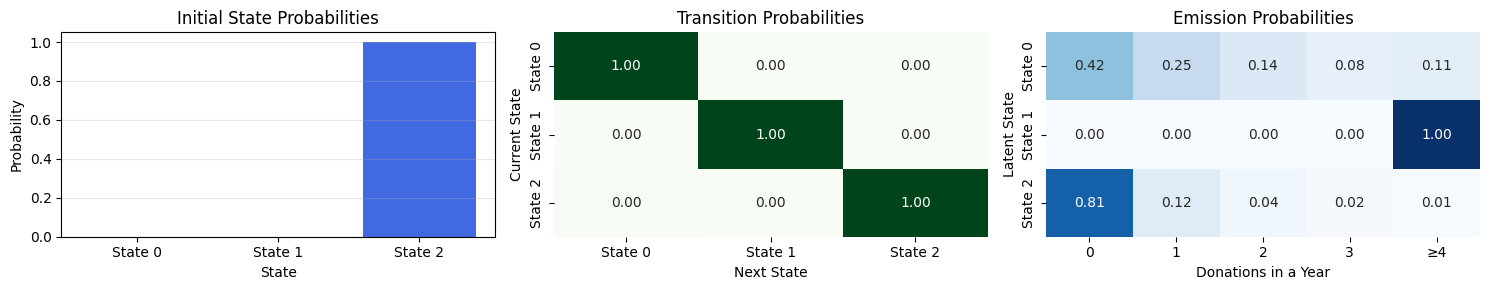

In [239]:
import numpy as np

store = pyro.get_param_store()          # comodo per fare debug

# ---------------- emissioni NB ---------------------------------
total_count  = pyro.param("total_count").detach().cpu().numpy()      # (K,)
emiss_logits = pyro.param("emiss_logits").detach().cpu().numpy()     # (K,)
probs        = 1 / (1 + np.exp(-emiss_logits))                       # sigmoid

print("Rate Negative Binomial per stato:")
for k in range(len(total_count)):
    print(f"  Stato {k}: total_count = {total_count[k]:.3f}, prob = {probs[k]:.3f}")

# ---------------- probabilità iniziali -------------------------
state_init_logits = pyro.param("state_init_logits").detach().cpu().numpy()  # (K,)
init_probs = np.exp(state_init_logits) / np.exp(state_init_logits).sum()

# ---------------- transizioni medie ----------------------------
K, C = pyro.param("trans_W").shape[-2:]
trans_W = pyro.param("trans_W").detach().cpu().numpy()   # (K, K, C)
trans_b = pyro.param("trans_b").detach().cpu().numpy()   # (K, K)

covs   = full_cov_torch.cpu().numpy()                   # (N, T, C)
covs_mean = covs[:, 0, :].mean(axis=0)                  # (C,)

transitions = np.zeros((K, K))
for prev in range(K):
    logits   = trans_b[prev] + trans_W[prev] @ covs_mean
    probs_tr = np.exp(logits) / np.exp(logits).sum()
    transitions[prev] = probs_tr

# ---------------- matrice di emissione (troncata) --------------
def build_emission_matrix_truncated_nbinom(tot_cnt, pr, max_k=4):
    from scipy.stats import nbinom
    S = len(tot_cnt)
    G = max_k + 1
    out = np.zeros((S, G))
    for s in range(S):
        for k in range(max_k):
            out[s, k] = nbinom.pmf(k, tot_cnt[s], pr[s])
        out[s, max_k] = 1 - nbinom.cdf(max_k - 1, 
                                       tot_cnt[s], pr[s])
    return out

emissions_matrix = build_emission_matrix_truncated_nbinom(total_count, probs)

# ---------------------- stampa e plot --------------------------
print("\nProbabilità iniziali (media popolazione):", init_probs)
print("Matrice di transizione (media covariate):\n", transitions)

plot_hmm_params(
    transitions=transitions,
    initial_probs=init_probs,
    emissions=emissions_matrix,
    emission_names=[str(i) for i in range(4)] + ["≥4"]
)

#### Viterbi algorithm

In [294]:
def infer_one_path_for_everybody():
    """
    Restituisce tensor (N, T) con il percorso di massima verosimiglianza
    per ogni donatore, usando i parametri correnti di Pyro.
    """
    with torch.no_grad():
        # prendi parametri ‘freezed’
        tot_cnt = pyro.param("total_count").detach()
        e_logits = pyro.param("emiss_logits").detach()
        init_logits = pyro.param("init_logits").detach()
        W   = pyro.param("trans_W").detach()
        b   = pyro.param("trans_b").detach()

        N, T = obs_torch.shape
        C    = full_cov_torch.size(2)
        paths = torch.zeros(N, T, dtype=torch.long)

        # pre-compute emission log-prob per ciascun (k,t,n)
        emis_log = torch.empty(N, T, K)
        for k in range(K):
            nb = dist.NegativeBinomial(total_count=tot_cnt[k],
                                       probs=torch.sigmoid(e_logits[k]))
            emis_log[:, :, k] = nb.log_prob(obs_torch)

        # loop sui donatori
        for n in range(N):
            # delta / psi per Viterbi
            delta = init_logits + emis_log[n, 0]          # (K,)
            psi   = torch.zeros(T, K, dtype=torch.long)

            for t in range(1, T):
                cov_t = full_cov_torch[n, t]              # (C,)
                # log-prob di transizione: shape (K_prev, K_next)
                logits = (W * cov_t).sum(-1) + b          # broadcast KxKxC → KxK
                log_trans = F.log_softmax(logits, dim=1)  # righe = prev
                # sommo a delta_prev (broadcast)
                score = delta[:, None] + log_trans        # (K_prev, K_next)
                delta, psi[t] = torch.max(score, dim=0)   # max over prev
                delta += emis_log[n, t]                   # aggiungo emissione

            # back-tracking
            last = torch.argmax(delta).item()
            paths[n, -1] = last
            for t in range(T-1, 0, -1):
                last = psi[t, last].item()
                paths[n, t-1] = last
        return paths
    
paths = infer_one_path_for_everybody()
switch = (paths[:,1:] != paths[:,:-1]).any(1).float().mean()
print("Sequenze con ≥1 switch:", switch.item()*100, "%")

Sequenze con ≥1 switch: 29.449978470802307 %


### Beta Binomial

#### 3 states

In [ ]:
# ───────────────────────── IMPORT ──────────────────────────
import torch, pyro, pyro.distributions as dist
from   pyro.infer        import SVI, TraceEnum_ELBO, config_enumerate
from   pyro.optim        import Adam
# from   pyro import constraints
import numpy as np
from   scipy.stats       import betabinom      # per diagnostica/plot

# ───────────────────────── COSTANTI ────────────────────────
K            = 3            # n. stati latenti
N_CATEGORIES = 5            # 0,1,2,3,4  (tot_count=4)

# prior “ragionevole” per Beta(a,b) di ogni stato
alpha0 = torch.ones(K) * 2.
beta0  = torch.ones(K) * 2.

# init prob. di stato
target_init_probs  = torch.tensor([0.60, 0.20, 0.20])
state_init_logits0 = torch.log(target_init_probs)

# helper per W quando serve C
def make_init_trans_W0(C):
    return 0.01 * torch.randn(K, K, C)

# ───────────────────────── MODEL ───────────────────────────
@config_enumerate
def model(obs, cov):
    N, T = obs.shape
    C    = cov.size(-1)

    # --- emissioni Beta-Binomiale --------------------------
    alpha = pyro.param("alpha",
                       alpha0.clone(), constraint=constraints.positive)
    beta  = pyro.param("beta",
                       beta0.clone(),  constraint=constraints.positive)

    # --- iniziali & transizioni ----------------------------
    state_init_logits = pyro.param("state_init_logits",
                                   state_init_logits0.clone())
    trans_W = pyro.param("trans_W", make_init_trans_W0(C))   # (K,K,C)
    trans_b = pyro.param("trans_b", torch.zeros(K, K))       # log-uniforme

    with pyro.plate("donors", N):
        z_prev = pyro.sample("z_0",
                             dist.Categorical(logits=state_init_logits),
                             infer={"enumerate": "parallel"})

        # t = 0
        pyro.sample("obs_0",
                    dist.BetaBinomial(alpha[z_prev], beta[z_prev],
                                    total_count=TOTAL),
                    obs=obs[:, 0])

        # t = 1 … T-1
        for t in range(1, T):
            logits = (trans_W[z_prev] * cov[:, t, None, :]).sum(-1) + trans_b[z_prev]
            z_t = pyro.sample(f"z_{t}",
                              dist.Categorical(logits=logits),
                              infer={"enumerate": "parallel"})

            pyro.sample(f"obs_{t}",
                        dist.BetaBinomial(alpha[z_t], beta[z_t],
                                        total_count=TOTAL),
                        obs=obs[:, t])
            z_prev = z_t

# ───────────────────────── GUIDE ───────────────────────────
def guide(obs, cov):
    N, T = obs.shape
    C    = cov.size(-1)

    trans_W_q     = pyro.param("trans_W_q", torch.zeros(K, K, C))
    trans_b_q     = pyro.param("trans_b_q", torch.zeros(K, K))
    init_logits_q = pyro.param("init_logits_q", torch.zeros(K))

    with pyro.plate("donors", N):
        z_prev = pyro.sample("z_0", dist.Categorical(logits=init_logits_q))
        for t in range(1, T):
            logits_q = (trans_W_q[z_prev] * cov[:, t, None, :]).sum(-1) + trans_b_q[z_prev]
            z_prev   = pyro.sample(f"z_{t}", dist.Categorical(logits=logits_q))

# ───────────────────────── TRAINING LOOP ──────────────────
TOTAL = torch.tensor(4, dtype=torch.long)
obs_torch = obs_torch.clamp_max(4).to(torch.long)

pyro.clear_param_store()
svi = SVI(model, guide, Adam({"lr":0.03,"betas":(0.9,0.999),"weight_decay":1e-4}),
          loss=TraceEnum_ELBO(max_plate_nesting=1))

for step in range(5_000):
    loss = svi.step(obs_torch, full_cov_torch)
    if step % 500 == 0:
        print(f"{step:5d}  ELBO = {loss:,.0f}")


c:\Users\erik4\AppData\Local\Programs\Python\Python313\Lib\site-packages\pyro\infer\traceenum_elbo.py:355: UserWarning: TraceEnum_ELBO found no sample sites configured for enumeration. If you want to enumerate sites, you need to @config_enumerate or set infer={"enumerate": "sequential"} or infer={"enumerate": "parallel"}? If you do not want to enumerate, consider using Trace_ELBO instead.
  warnings.warn(


    0  ELBO = 241,997
  500  ELBO = 152,013
 1000  ELBO = 150,972
 1500  ELBO = 150,649
 2000  ELBO = 150,579
 2500  ELBO = 150,238
 3000  ELBO = 150,219


KeyboardInterrupt: 


Beta-Binomiale per stato (n=4):
  stato 0: alpha=1.23  beta=3.03 p=0.289  E[X]=1.16
  stato 1: alpha=0.72  beta=3.07 p=0.191  E[X]=0.76
  stato 2: alpha=0.17  beta=1.99 p=0.080  E[X]=0.32

Probabilità iniziali: [2.0746983e-04 2.6168424e-04 9.9953091e-01]
Matrice di transizione (media covariate):
 [[5.03704727e-01 4.94291425e-01 2.00382434e-03]
 [4.15173322e-01 1.06857708e-02 5.74140906e-01]
 [4.20689139e-05 3.29077523e-03 9.96667147e-01]]


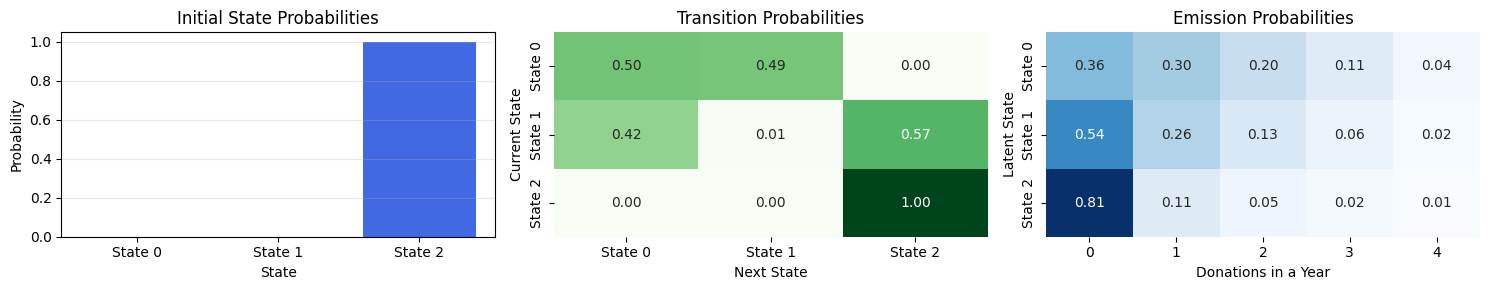

In [254]:

# ───────────────────────── DIAGNOSTICA ─────────────────────
alpha_hat = pyro.param("alpha").detach().cpu().numpy()   # (K,)
beta_hat  = pyro.param("beta").detach().cpu().numpy()

p_hat     = alpha_hat / (alpha_hat + beta_hat)           # mean di Beta
mu_hat    = 4 * p_hat                                    # media del conteggio

init_log  = pyro.param("state_init_logits").detach().cpu().numpy()
init_prob = np.exp(init_log) / np.exp(init_log).sum()

W = pyro.param("trans_W").detach().cpu().numpy()         # (K,K,C)
b = pyro.param("trans_b").detach().cpu().numpy()         # (K,K)
cov_mean = full_cov_torch[:, 0, :].mean(0).cpu().numpy()

P = np.zeros((K, K))
for k in range(K):
    logits = b[k] + W[k] @ cov_mean
    P[k]   = np.exp(logits) / np.exp(logits).sum()

print("\nBeta-Binomiale per stato (n=4):")
for k in range(K):
    print(f"  stato {k}: alpha={alpha_hat[k]:.2f}  beta={beta_hat[k]:.2f} "
          f"p={p_hat[k]:.3f}  E[X]={mu_hat[k]:.2f}")
print("\nProbabilità iniziali:", init_prob)
print("Matrice di transizione (media covariate):\n", P)

# ───────────────────── EMISSION MATRIX (opz.) ──────────────
def build_emission_matrix_betabinom(alpha, beta, total_count=4):
    S = len(alpha)
    M = np.zeros((S, total_count + 1))
    for s in range(S):
        for k in range(total_count + 1):
            M[s, k] = betabinom.pmf(k, total_count, alpha[s], beta[s])
    return M

emission_mat = build_emission_matrix_betabinom(alpha_hat, beta_hat)

plot_hmm_params(transitions=P,
    initial_probs=init_prob,
    emissions=emission_mat,
    emission_names=[str(i) for i in range(5)])

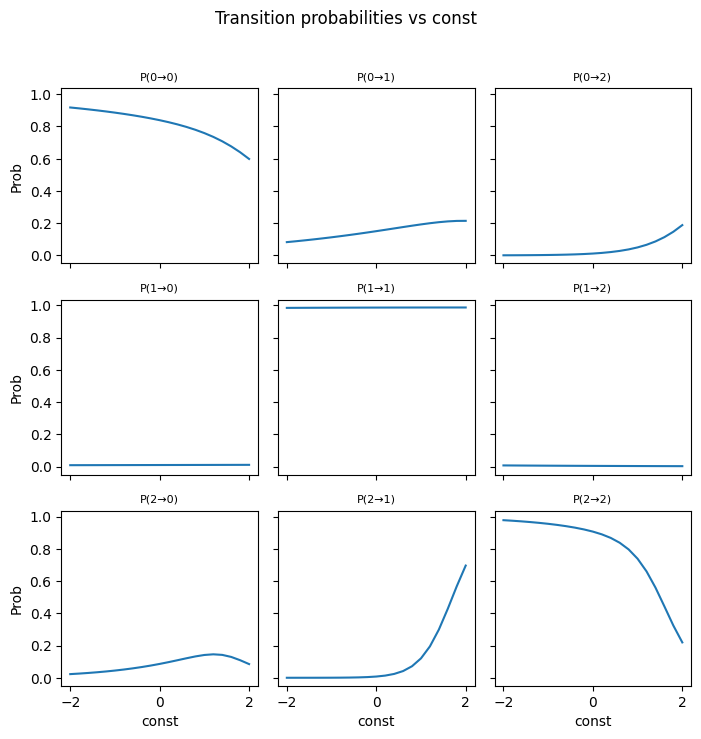

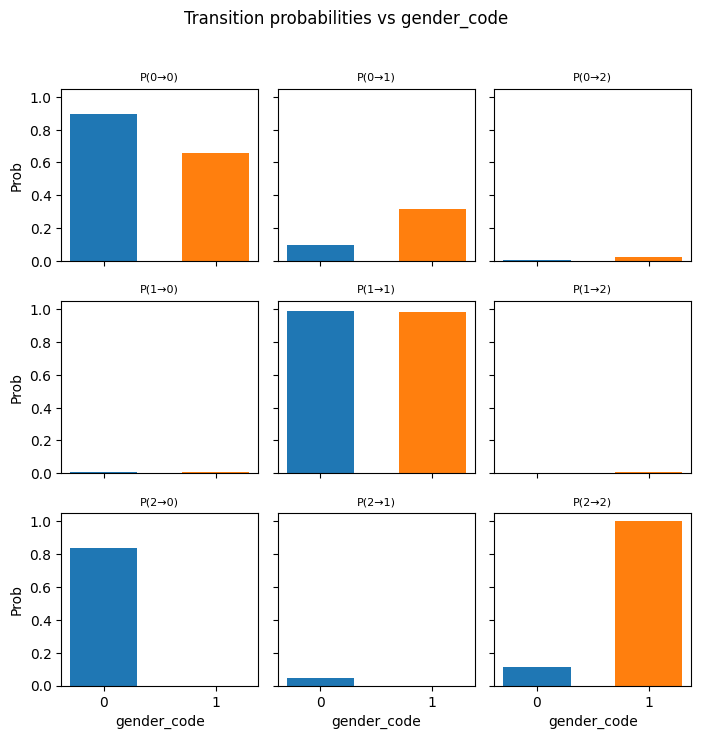

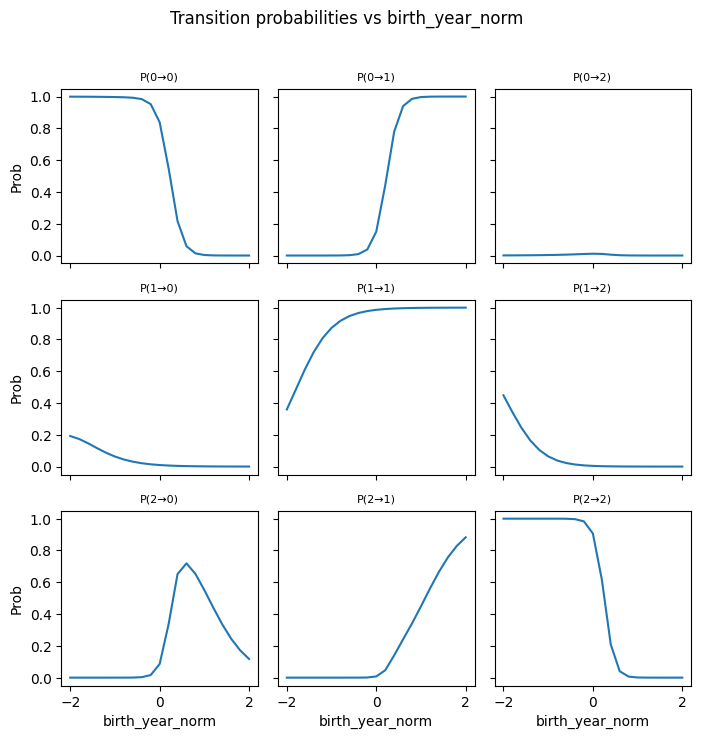

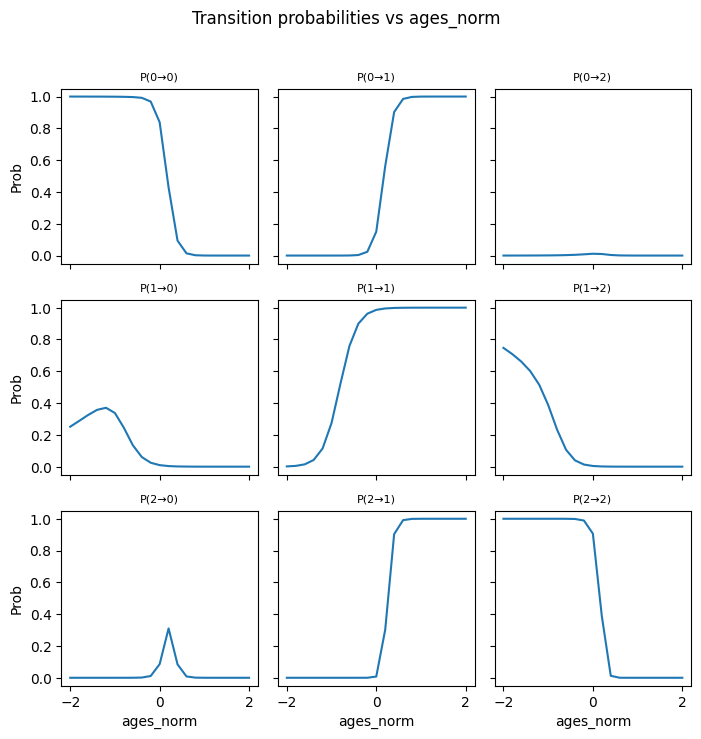

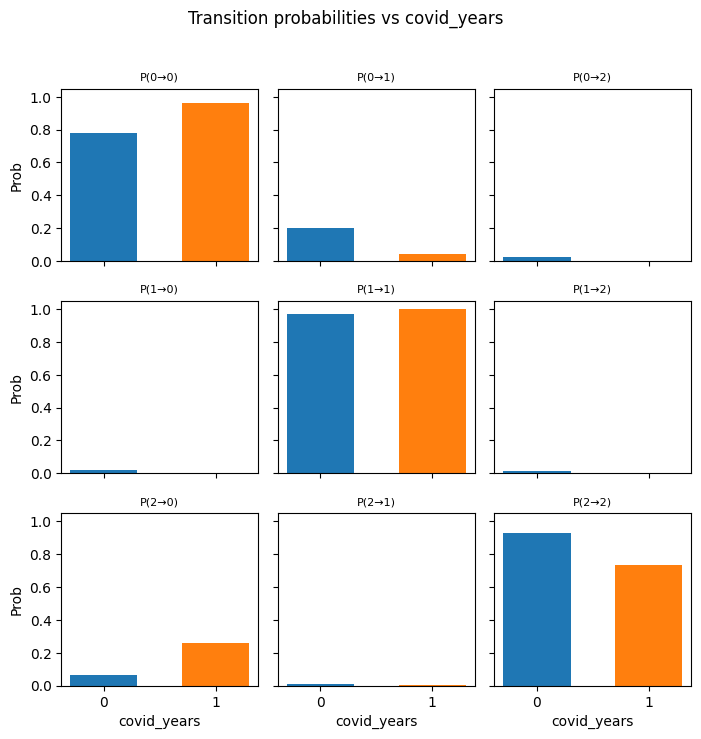

In [255]:
import numpy as np
import matplotlib.pyplot as plt

def plot_transition_grid(var_name, covariate_names,
                         trans_b, trans_W, full_covariates,
                         grid_vals=None):
    """
    Draws K×K small multiples of transition probabilities versus a covariate.

    • If the covariate has ≤2 distinct values -> bar plot (one bar per value).  
    • Otherwise -> line plot on grid_vals (default linspace(-2, 2, 21)).
    """
    K   = trans_b.shape[0]
    idx = covariate_names.index(var_name)

    # ------------------------------------------------------------------
    # Choose values at which to evaluate the covariate
    # ------------------------------------------------------------------
    if grid_vals is None:
        unique_vals = np.unique(full_covariates[..., idx])

        # Treat as categorical when two or fewer distinct values exist
        if len(unique_vals) <= 2:
            grid_vals = unique_vals.astype(float)
            plot_mode = "bar"
        else:
            grid_vals = np.linspace(-2, 2, 21)
            plot_mode = "line"
    else:
        plot_mode = "line"

    # ------------------------------------------------------------------
    # Build transition matrices for each value in grid_vals
    # ------------------------------------------------------------------
    covs_mean = full_covariates.mean(axis=(0, 1))      # Shape [C]
    matrices  = []                                     # Will become (G, K, K)

    for v in grid_vals:
        x = covs_mean.copy()
        x[idx] = v
        P = []
        for prev in range(K):
            logits = trans_b[prev] + trans_W[prev] @ x
            probs  = np.exp(logits) / np.exp(logits).sum()
            P.append(probs)
        matrices.append(np.vstack(P))

    matrices = np.stack(matrices)  # Shape (G, K, K)

    # ------------------------------------------------------------------
    # Plotting
    # ------------------------------------------------------------------
    fig, axes = plt.subplots(K, K, figsize=(K*2.4, K*2.4),
                             sharex=True, sharey=True)

    for i in range(K):
        for j in range(K):
            ax = axes[i, j]
            if plot_mode == "line":
                ax.plot(grid_vals, matrices[:, i, j])
            else:  # bar plot
                bar_width = 0.6
                ax.bar(grid_vals, matrices[:, i, j],
                       width=bar_width, color=['#1f77b4', '#ff7f0e'])
                ax.set_xticks(grid_vals)

            ax.set_title(f"P({i}→{j})", fontsize=8)
            if i == K - 1:
                ax.set_xlabel(var_name)
            if j == 0:
                ax.set_ylabel("Prob")

    plt.suptitle(f"Transition probabilities vs {var_name}", y=1.02)
    plt.tight_layout()
    plt.show()


# ------------------------------------------------------------------
# Call the function for every covariate in the CORRECT order
# ------------------------------------------------------------------
cov_names = [
    "const",
             "gender_code",      # 1 binary
            "birth_year_norm",  # 0 continuous
             "ages_norm",        # 2 continuous
             "covid_years"]      # 3 binary

for name in cov_names:
    plot_transition_grid(name, cov_names,
                         trans_b, trans_W, full_covariates)


Occupancy medio per stato:
  stato 0: 0.471
  stato 1: 0.111
  stato 2: 0.418

Curva di 'sopravvivenza' (P(z_t == 2)):
  t= 0:  0.995
  t= 1:  0.668
  t= 2:  0.627
  t= 3:  0.591
  t= 4:  0.562
  t= 5:  0.535
  t= 6:  0.507
  t= 7:  0.479
  t= 8:  0.452
  t= 9:  0.426
  t=10:  0.400
  t=11:  0.014
  t=12:  0.002
  t=13:  0.000
  t=14:  0.005


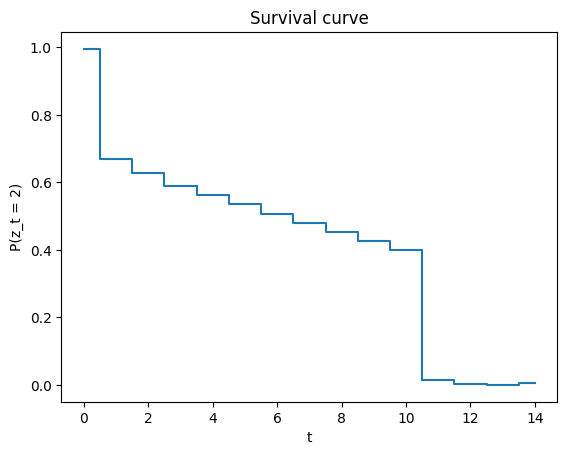

In [259]:
import torch
import pyro
import pyro.distributions as dist

def posterior_diagnostics(obs, cov, state_of_interest=2):
    """
    obs : LongTensor  [N,T]        (0…4)
    cov : FloatTensor [N,T,C]
    Restituisce:
        occ       : Tensor[K]      frequenza media degli stati
        surv_curve: Tensor[T]      P(z_t == state_of_interest)
    """
    device = obs.device
    N, T   = obs.shape
    C      = cov.size(-1)

    # ---- parametri appresi -----------------------------------------------
    alpha = pyro.param("alpha").to(device)          # (K,)
    beta  = pyro.param("beta").to(device)           # (K,)
    init_logits = pyro.param("state_init_logits").to(device)   # (K,)

    W = pyro.param("trans_W").to(device)            # (K,K,C)
    b = pyro.param("trans_b").to(device)            # (K,K)
    K   = alpha.size(0)
    TOTAL = torch.tensor(4, dtype=torch.long, device=device)

    # ---- emission log-prob  e_t[n,k] -------------------------------------
    # e_t[n,k] = log P(x_{n,t} | z_{n,t}=k)
    emission_lp = torch.empty(N, T, K, device=device)
    for k in range(K):
        d = dist.BetaBinomial(alpha[k], beta[k], total_count=TOTAL)
        emission_lp[..., k] = d.log_prob(obs)

    # ---- forward pass -----------------------------------------------------
    log_init = init_logits - torch.logsumexp(init_logits, 0)   # log prob
    log_alpha = torch.empty(N, T, K, device=device)

    # t = 0
    log_alpha[:, 0, :] = log_init + emission_lp[:, 0, :]

    # t = 1 … T-1
    for t in range(1, T):
        # trans_logits[n,prev,next]
        trans_logits = torch.einsum('nc,klc->nkl', cov[:, t, :], W) + b
        trans_lp = trans_logits - torch.logsumexp(trans_logits, dim=2, keepdim=True)

        # log_alpha_new[n,next] = logsum_prev log_alpha_prev + logP(prev→next)
        log_alpha_prev = log_alpha[:, t-1, :].unsqueeze(2)          # (N,prev,1)
        log_alpha[:, t, :] = torch.logsumexp(log_alpha_prev + trans_lp, dim=1) \
                             + emission_lp[:, t, :]

    # ---- backward pass ----------------------------------------------------
    log_beta = torch.zeros(N, T, K, device=device)

    for t in reversed(range(T-1)):
        trans_logits = torch.einsum('nc,klc->nkl', cov[:, t+1, :], W) + b
        trans_lp = trans_logits - torch.logsumexp(trans_logits, dim=2, keepdim=True)

        # log_beta_t[prev] = logsum_next  logP(prev→next) + e_{t+1}(next) + beta_{t+1}(next)
        tmp = trans_lp + emission_lp[:, t+1, :].unsqueeze(1) + log_beta[:, t+1, :].unsqueeze(1)
        log_beta[:, t, :] = torch.logsumexp(tmp, dim=2)

    # ---- marginale gamma --------------------------------------------------
    log_gamma = log_alpha + log_beta
    log_Z = torch.logsumexp(log_gamma, dim=2, keepdim=True)    # normalizz.
    gamma   = (log_gamma - log_Z).exp()                       # (N,T,K)

    # ---- diagnostiche -----------------------------------------------------
    occupancy = gamma.mean(dim=(0,1))                         # K
    surv_curve = gamma[:, :, state_of_interest].mean(dim=0)   # T

    return occupancy.cpu(), surv_curve.cpu()

# --------------------------------------------------------------------------
occ, surv = posterior_diagnostics(obs_torch, full_cov_torch)

print("\nOccupancy medio per stato:")
for k, p in enumerate(occ):
    print(f"  stato {k}: {p:.3f}")

print("\nCurva di 'sopravvivenza' (P(z_t == 2)):")
for t, p in enumerate(surv):
    print(f"  t={t:2d}:  {p:.3f}")

surv = surv.detach().numpy()  # convert to numpy for plotting
plt.step(range(len(surv)), surv, where='mid')
plt.xlabel('t'); plt.ylabel('P(z_t = 2)'); plt.title('Survival curve')
plt.show()

#### 4 states


In [272]:
# ───────────────────────── IMPORT ──────────────────────────
import torch, pyro, pyro.distributions as dist
from   pyro.infer        import SVI, TraceEnum_ELBO, config_enumerate
from   pyro.optim        import Adam
# from   pyro import constraints
import numpy as np
from   scipy.stats       import betabinom      # opz.

# ───────────────────────── COSTANTI ────────────────────────
K            = 4            # n. stati latenti   <─── cambiato
N_CATEGORIES = 5            # 0,1,2,3,4  (tot_count=4)

# prior “ragionevole” per Beta(a,b) di ogni stato (qui ben distinti)
alpha0 = torch.tensor([3., 2., 1., 0.5])    # shape (K,)
beta0  = torch.tensor([1., 2., 3., 5.])

# init prob. di stato (qui poco informative ≃ uniformi)
target_init_probs  = torch.tensor([0.25, 0.25, 0.25, 0.25])
state_init_logits0 = torch.log(target_init_probs)

# helper per W quando serve C
def make_init_trans_W0(C):
    return 0.01 * torch.randn(K, K, C)

# ───────────────────────── MODEL ───────────────────────────
@config_enumerate
def model(obs, cov):
    N, T = obs.shape
    C    = cov.size(-1)

    # --- emissioni Beta-Binomiale --------------------------
    alpha = pyro.param("alpha",
                       alpha0.clone(), constraint=constraints.positive)
    beta  = pyro.param("beta",
                       beta0.clone(),  constraint=constraints.positive)

    # --- iniziali & transizioni ----------------------------
    state_init_logits = pyro.param("state_init_logits",
                                   state_init_logits0.clone())
    trans_W = pyro.param("trans_W", make_init_trans_W0(C))   # (K,K,C)
    trans_b = pyro.param("trans_b", torch.zeros(K, K))       # log-uniforme

    with pyro.plate("donors", N):
        z_prev = pyro.sample("z_0",
                             dist.Categorical(logits=state_init_logits),
                             infer={"enumerate": "parallel"})

        # t = 0
        pyro.sample("obs_0",
                    dist.BetaBinomial(alpha[z_prev], beta[z_prev],
                                      total_count=TOTAL),
                    obs=obs[:, 0])

        # t = 1 … T-1
        for t in range(1, T):
            logits = (trans_W[z_prev] * cov[:, t, None, :]).sum(-1) + trans_b[z_prev]
            z_t = pyro.sample(f"z_{t}",
                              dist.Categorical(logits=logits),
                              infer={"enumerate": "parallel"})

            pyro.sample(f"obs_{t}",
                        dist.BetaBinomial(alpha[z_t], beta[z_t],
                                          total_count=TOTAL),
                        obs=obs[:, t])
            z_prev = z_t

# ───────────────────────── GUIDE ───────────────────────────
@config_enumerate
def guide(obs, cov):
    N, T = obs.shape
    C    = cov.size(-1)

    trans_W_q     = pyro.param("trans_W_q", torch.zeros(K, K, C))
    trans_b_q     = pyro.param("trans_b_q", torch.zeros(K, K))
    init_logits_q = pyro.param("init_logits_q", torch.zeros(K))

    with pyro.plate("donors", N):
        z_prev = pyro.sample("z_0", dist.Categorical(logits=init_logits_q))
        for t in range(1, T):
            logits_q = (trans_W_q[z_prev] * cov[:, t, None, :]).sum(-1) + trans_b_q[z_prev]
            z_prev   = pyro.sample(f"z_{t}", dist.Categorical(logits=logits_q))

# ───────────────────────── TRAINING LOOP ──────────────────
TOTAL = torch.tensor(4, dtype=torch.long)
obs_torch = obs_torch.clamp_max(4).to(torch.long)

pyro.clear_param_store()
optimizer = Adam({"lr":0.03, "betas":(0.9,0.999), "weight_decay":1e-4})
svi       = SVI(model, guide, optimizer,
                loss=TraceEnum_ELBO(max_plate_nesting=1))

for step in range(2_000):
    loss = svi.step(obs_torch, full_cov_torch)
    if step % 200 == 0:
        print(f"{step:5d}  ELBO = {loss:,.0f}")

    0  ELBO = 247,029
  200  ELBO = 151,098
  400  ELBO = 150,070
  600  ELBO = 149,580
  800  ELBO = 149,276
 1000  ELBO = 149,104
 1200  ELBO = 148,959
 1400  ELBO = 148,791
 1600  ELBO = 148,693
 1800  ELBO = 148,623



Beta-Binomiale per stato (n=4):
  stato 0: alpha=0.90  beta=3.44 p=0.207  E[X]=0.83
  stato 1: alpha=1.28  beta=3.14 p=0.290  E[X]=1.16
  stato 2: alpha=0.38  beta=2.67 p=0.125  E[X]=0.50
  stato 3: alpha=0.06  beta=1.15 p=0.050  E[X]=0.20

Probabilità iniziali: [2.1687540e-04 1.8701141e-05 2.6436470e-04 9.9950004e-01]
Matrice di transizione (media covariate):
 [[2.58958619e-02 6.24668561e-02 5.75731218e-01 3.35906059e-01]
 [1.17316132e-03 9.33931708e-01 6.44500107e-02 4.45120648e-04]
 [5.96034124e-06 9.39638176e-06 9.99972701e-01 1.19143069e-05]
 [3.56739183e-04 1.16789437e-04 9.82300282e-01 1.72261577e-02]]


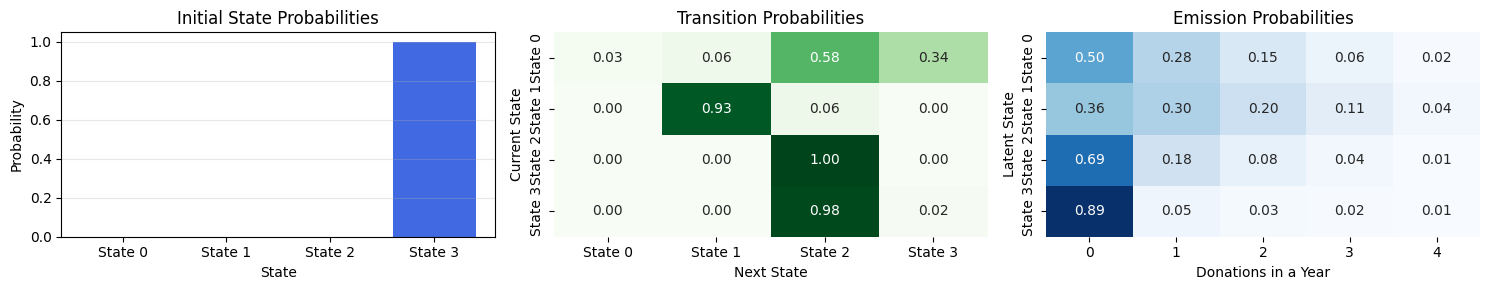

In [273]:

# ───────────────────────── DIAGNOSTICA ─────────────────────
alpha_hat = pyro.param("alpha").detach().cpu().numpy()   # (K,)
beta_hat  = pyro.param("beta").detach().cpu().numpy()

p_hat     = alpha_hat / (alpha_hat + beta_hat)           # mean di Beta
mu_hat    = 4 * p_hat                                    # media del conteggio

init_log  = pyro.param("state_init_logits").detach().cpu().numpy()
init_prob = np.exp(init_log) / np.exp(init_log).sum()

W = pyro.param("trans_W").detach().cpu().numpy()         # (K,K,C)
b = pyro.param("trans_b").detach().cpu().numpy()         # (K,K)
cov_mean = full_cov_torch[:, 0, :].mean(0).cpu().numpy()

P = np.zeros((K, K))
for k in range(K):
    logits = b[k] + W[k] @ cov_mean
    P[k]   = np.exp(logits) / np.exp(logits).sum()

print("\nBeta-Binomiale per stato (n=4):")
for k in range(K):
    print(f"  stato {k}: alpha={alpha_hat[k]:.2f}  beta={beta_hat[k]:.2f} "
          f"p={p_hat[k]:.3f}  E[X]={mu_hat[k]:.2f}")
print("\nProbabilità iniziali:", init_prob)
print("Matrice di transizione (media covariate):\n", P)

# ───────────────────── EMISSION MATRIX (opz.) ──────────────
def build_emission_matrix_betabinom(alpha, beta, total_count=4):
    S = len(alpha)
    M = np.zeros((S, total_count + 1))
    for s in range(S):
        for k in range(total_count + 1):
            M[s, k] = betabinom.pmf(k, total_count, alpha[s], beta[s])
    return M

emission_mat = build_emission_matrix_betabinom(alpha_hat, beta_hat)

plot_hmm_params(transitions=P,
    initial_probs=init_prob,
    emissions=emission_mat,
    emission_names=[str(i) for i in range(5)])

#### 2 states

In [ ]:
# ───────────────────────── IMPORT ──────────────────────────
import torch, pyro, pyro.distributions as dist
from   pyro.infer        import SVI, TraceEnum_ELBO, config_enumerate
from   pyro.optim        import Adam
# from   pyro import constraints
import numpy as np
from   scipy.stats       import betabinom      # opz.

# ───────────────────────── COSTANTI ────────────────────────
K            = 4            # n. stati latenti   <─── cambiato
N_CATEGORIES = 5            # 0,1,2,3,4  (tot_count=4)

# prior “ragionevole” per Beta(a,b) di ogni stato (qui ben distinti)
alpha0 = torch.tensor([3., 2., 1., 0.5])    # shape (K,)
beta0  = torch.tensor([1., 2., 3., 5.])

# init prob. di stato (qui poco informative ≃ uniformi)
target_init_probs  = torch.tensor([0.25, 0.25, 0.25, 0.25])
state_init_logits0 = torch.log(target_init_probs)

# helper per W quando serve C
def make_init_trans_W0(C):
    return 0.01 * torch.randn(K, K, C)

# ───────────────────────── MODEL ───────────────────────────
@config_enumerate
def model(obs, cov):
    N, T = obs.shape
    C    = cov.size(-1)

    # --- emissioni Beta-Binomiale --------------------------
    alpha = pyro.param("alpha",
                       alpha0.clone(), constraint=constraints.positive)
    beta  = pyro.param("beta",
                       beta0.clone(),  constraint=constraints.positive)

    # --- iniziali & transizioni ----------------------------
    state_init_logits = pyro.param("state_init_logits",
                                   state_init_logits0.clone())
    trans_W = pyro.param("trans_W", make_init_trans_W0(C))   # (K,K,C)
    trans_b = pyro.param("trans_b", torch.zeros(K, K))       # log-uniforme

    with pyro.plate("donors", N):
        z_prev = pyro.sample("z_0",
                             dist.Categorical(logits=state_init_logits),
                             infer={"enumerate": "parallel"})

        # t = 0
        pyro.sample("obs_0",
                    dist.BetaBinomial(alpha[z_prev], beta[z_prev],
                                      total_count=TOTAL),
                    obs=obs[:, 0])

        # t = 1 … T-1
        for t in range(1, T):
            logits = (trans_W[z_prev] * cov[:, t, None, :]).sum(-1) + trans_b[z_prev]
            z_t = pyro.sample(f"z_{t}",
                              dist.Categorical(logits=logits),
                              infer={"enumerate": "parallel"})

            pyro.sample(f"obs_{t}",
                        dist.BetaBinomial(alpha[z_t], beta[z_t],
                                          total_count=TOTAL),
                        obs=obs[:, t])
            z_prev = z_t

# ───────────────────────── GUIDE ───────────────────────────
@config_enumerate
def guide(obs, cov):
    N, T = obs.shape
    C    = cov.size(-1)

    trans_W_q     = pyro.param("trans_W_q", torch.zeros(K, K, C))
    trans_b_q     = pyro.param("trans_b_q", torch.zeros(K, K))
    init_logits_q = pyro.param("init_logits_q", torch.zeros(K))

    with pyro.plate("donors", N):
        z_prev = pyro.sample("z_0", dist.Categorical(logits=init_logits_q))
        for t in range(1, T):
            logits_q = (trans_W_q[z_prev] * cov[:, t, None, :]).sum(-1) + trans_b_q[z_prev]
            z_prev   = pyro.sample(f"z_{t}", dist.Categorical(logits=logits_q))

# ───────────────────────── TRAINING LOOP ──────────────────
TOTAL = torch.tensor(4, dtype=torch.long)
obs_torch = obs_torch.clamp_max(4).to(torch.long)

pyro.clear_param_store()
optimizer = Adam({"lr":0.03, "betas":(0.9,0.999), "weight_decay":1e-4})
svi       = SVI(model, guide, optimizer,
                loss=TraceEnum_ELBO(max_plate_nesting=1))

for step in range(2_000):
    loss = svi.step(obs_torch, full_cov_torch)
    if step % 200 == 0:
        print(f"{step:5d}  ELBO = {loss:,.0f}")

    0  ELBO = 247,029
  200  ELBO = 151,098
  400  ELBO = 150,070
  600  ELBO = 149,580
  800  ELBO = 149,276
 1000  ELBO = 149,104
 1200  ELBO = 148,959
 1400  ELBO = 148,791
 1600  ELBO = 148,693
 1800  ELBO = 148,623



Beta-Binomiale per stato (n=4):
  stato 0: alpha=0.90  beta=3.44 p=0.207  E[X]=0.83
  stato 1: alpha=1.28  beta=3.14 p=0.290  E[X]=1.16
  stato 2: alpha=0.38  beta=2.67 p=0.125  E[X]=0.50
  stato 3: alpha=0.06  beta=1.15 p=0.050  E[X]=0.20

Probabilità iniziali: [2.1687540e-04 1.8701141e-05 2.6436470e-04 9.9950004e-01]
Matrice di transizione (media covariate):
 [[2.58958619e-02 6.24668561e-02 5.75731218e-01 3.35906059e-01]
 [1.17316132e-03 9.33931708e-01 6.44500107e-02 4.45120648e-04]
 [5.96034124e-06 9.39638176e-06 9.99972701e-01 1.19143069e-05]
 [3.56739183e-04 1.16789437e-04 9.82300282e-01 1.72261577e-02]]


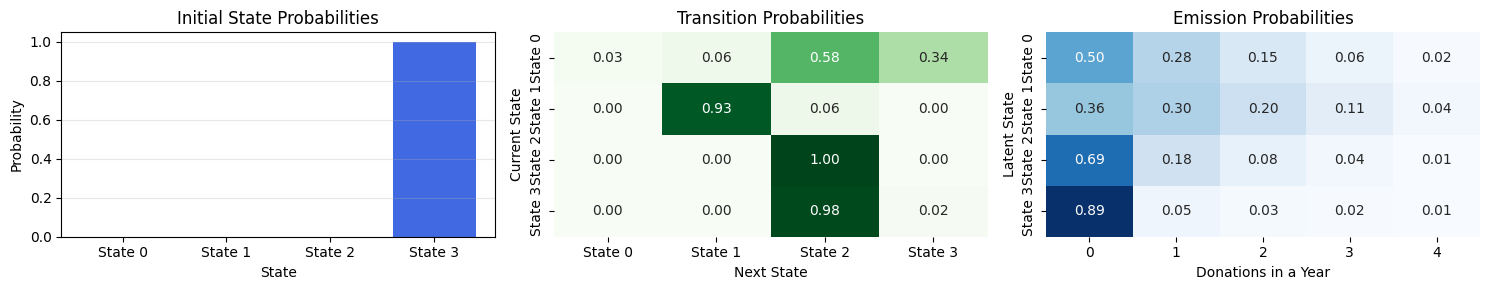

In [ ]:

# ───────────────────────── DIAGNOSTICA ─────────────────────
alpha_hat = pyro.param("alpha").detach().cpu().numpy()   # (K,)
beta_hat  = pyro.param("beta").detach().cpu().numpy()

p_hat     = alpha_hat / (alpha_hat + beta_hat)           # mean di Beta
mu_hat    = 4 * p_hat                                    # media del conteggio

init_log  = pyro.param("state_init_logits").detach().cpu().numpy()
init_prob = np.exp(init_log) / np.exp(init_log).sum()

W = pyro.param("trans_W").detach().cpu().numpy()         # (K,K,C)
b = pyro.param("trans_b").detach().cpu().numpy()         # (K,K)
cov_mean = full_cov_torch[:, 0, :].mean(0).cpu().numpy()

P = np.zeros((K, K))
for k in range(K):
    logits = b[k] + W[k] @ cov_mean
    P[k]   = np.exp(logits) / np.exp(logits).sum()

print("\nBeta-Binomiale per stato (n=4):")
for k in range(K):
    print(f"  stato {k}: alpha={alpha_hat[k]:.2f}  beta={beta_hat[k]:.2f} "
          f"p={p_hat[k]:.3f}  E[X]={mu_hat[k]:.2f}")
print("\nProbabilità iniziali:", init_prob)
print("Matrice di transizione (media covariate):\n", P)

# ───────────────────── EMISSION MATRIX (opz.) ──────────────
def build_emission_matrix_betabinom(alpha, beta, total_count=4):
    S = len(alpha)
    M = np.zeros((S, total_count + 1))
    for s in range(S):
        for k in range(total_count + 1):
            M[s, k] = betabinom.pmf(k, total_count, alpha[s], beta[s])
    return M

emission_mat = build_emission_matrix_betabinom(alpha_hat, beta_hat)

plot_hmm_params(transitions=P,
    initial_probs=init_prob,
    emissions=emission_mat,
    emission_names=[str(i) for i in range(5)])

### Poisson

In Adam the adaptive *loss ratio* —sometimes called the *adaptive step*— is the
term that multiplies the global learning rate $\eta$ in the update rule.  It is

$$
r_t \;=\; \frac{\hat{m}_t}{\sqrt{\hat{v}_t} + \varepsilon},
$$

so the full step is $\Delta\theta_t = \eta \, r_t$.  
Here $\hat{m}_t$ and $\hat{v}_t$ are the bias-corrected first and second
moments:

$$
\hat{m}_t = \frac{m_t}{1-\beta_{1}^{\,t}},\qquad
\hat{v}_t = \frac{v_t}{1-\beta_{2}^{\,t}},
$$

with the raw moments evolving as

$$
m_t = \beta_{1}\, m_{t-1} + (1-\beta_{1})\, g_t, \qquad\!
v_t = \beta_{2}\, v_{t-1} + (1-\beta_{2})\, g_t^{\,2}.
$$

Intuitively $r_t$ is an estimate of the **signal-to-noise ratio** of the
gradient: the mean divided by its (biased) standard deviation.  Large variance
($\hat{v}_t$ high) shrinks the step; a consistent gradient direction
($\hat{m}_t$ high) enlarges it.  The small constant $\varepsilon$ only prevents
division by zero.

Thanks to this ratio Adam automatically scales each parameter’s step: units are
normalised, steps are bigger where gradients are stable and smaller where they
are noisy, making optimisation fast yet robust.

In Adam the *betas* are the exponential–decay coefficients that decide how fast
the optimiser forgets past gradients.  
Inline example: the default values are $\beta_1 = 0.9$ and $\beta_2 = 0.999$.

$$
m_t = \beta_{1}\, m_{t-1} + (1-\beta_{1})\, g_t
\qquad\text{(first moment)}
$$

$$
v_t = \beta_{2}\, v_{t-1} + (1-\beta_{2})\, g_t^{\,2}
\qquad\text{(second moment)}
$$

The raw averages are bias-corrected:

$$
\hat{m}_t = \frac{m_t}{1-\beta_{1}^{\,t}},
\qquad
\hat{v}_t = \frac{v_t}{1-\beta_{2}^{\,t}}
$$

Finally, the parameter update is

$$
\theta_{t+1} = \theta_t - \eta \,
               \frac{\hat{m}_t}{\sqrt{\hat{v}_t} + \varepsilon}\;.
$$

Higher betas (closer to $1$) smooth the statistics and make optimisation more
stable but slower to adapt; lower betas react faster at the cost of extra
noise.

`TraceEnum_ELBO` is Pyro’s loss object that computes the evidence lower bound
(ELBO) while **exactly enumerating** all discrete latent variables.

• Trace — records the full execution graph of model and guide.  
• Enum — replaces sampling of discrete latents with summation over every
  possible value, giving a low-variance ELBO gradient.  

The line

```python
loss = TraceEnum_ELBO(max_plate_nesting=1)
```

adds the hint `max_plate_nesting=1`, meaning that any enumerated variable can
sit inside at most **one** nested `pyro.plate`.  
This guides Pyro’s shape bookkeeping so that enumerated dimensions broadcast
correctly and memory usage stays tight.

In [6]:
# ───────────────────────── IMPORT ──────────────────────────
import torch, pyro, pyro.distributions as dist
from   pyro.infer        import SVI, TraceEnum_ELBO, config_enumerate
from   pyro.optim        import Adam
# from   pyro import constraints                      # ← serve per λ>0
import numpy as np

# ───────────────────────── COSTANTI ────────────────────────
K = 3                          # n. stati latenti

# prior “ragionevole” per il rate Poisson di ogni stato
rate0 = torch.ones(K) * 1.0    # λ iniziali (si possono cambiare)

# probabilità iniziali
target_init_probs  = torch.tensor([0.60, 0.20, 0.20])
state_init_logits0 = torch.log(target_init_probs)

# helper per inizializzare i pesi di transizione
def make_init_trans_W0(C):
    return 0.01 * torch.randn(K, K, C)

# ───────────────────────── MODEL ───────────────────────────
@config_enumerate
def model(obs, cov):
    N, T = obs.shape
    C    = cov.size(-1)

    # --- emissioni Poisson ---------------------------------
    rate = pyro.param("rate",
                      rate0.clone(), constraint=constraints.positive)  # (K,)

    # --- iniziali & transizioni ----------------------------
    state_init_logits = pyro.param("state_init_logits",
                                   state_init_logits0.clone())          # (K,)
    trans_W = pyro.param("trans_W", make_init_trans_W0(C))              # (K,K,C)
    trans_b = pyro.param("trans_b", torch.zeros(K, K))                  # (K,K)

    with pyro.plate("donors", N):
        # stato iniziale
        z_prev = pyro.sample("z_0",
                             dist.Categorical(logits=state_init_logits),
                             infer={"enumerate": "parallel"})

        # t = 0 --------------------------------------------------------
        pyro.sample("obs_0",
                    dist.Poisson(rate[z_prev]),
                    obs=obs[:, 0])

        # t = 1 … T-1 -------------------------------------------------
        for t in range(1, T):
            logits = (trans_W[z_prev] * cov[:, t, None, :]).sum(-1) + trans_b[z_prev]
            z_t = pyro.sample(f"z_{t}",
                              dist.Categorical(logits=logits),
                              infer={"enumerate": "parallel"})

            pyro.sample(f"obs_{t}",
                        dist.Poisson(rate[z_t]),
                        obs=obs[:, t])
            z_prev = z_t

# ───────────────────────── GUIDE ───────────────────────────
@config_enumerate
def guide(obs, cov):
    N, T = obs.shape
    C    = cov.size(-1)

    trans_W_q     = pyro.param("trans_W_q", torch.zeros(K, K, C))
    trans_b_q     = pyro.param("trans_b_q", torch.zeros(K, K))
    init_logits_q = pyro.param("init_logits_q", torch.zeros(K))

    with pyro.plate("donors", N):
        z_prev = pyro.sample("z_0", dist.Categorical(logits=init_logits_q))
        for t in range(1, T):
            logits_q = (trans_W_q[z_prev] * cov[:, t, None, :]).sum(-1) + trans_b_q[z_prev]
            z_prev   = pyro.sample(f"z_{t}", dist.Categorical(logits=logits_q))

# ───────────────────────── TRAINING LOOP ──────────────────
pyro.clear_param_store()
svi = SVI(model, guide,
          Adam({"lr": 0.03, "betas": (0.9, 0.999), "weight_decay": 1e-4}),
          loss=TraceEnum_ELBO(max_plate_nesting=1))

for step in range(2_000):
    loss = svi.step(obs_torch, full_cov_torch)       # <-- tuoi tensori (N,T) e (N,T,C)
    if step % 200 == 0:
        print(f"{step:5d}  ELBO = {loss:,.0f}")

# ───────────────────────── DIAGNOSTICA RAPIDA ─────────────
print("Rate Poisson stimati:", pyro.param("rate").detach().cpu().numpy())
print("Prob. iniziali:", torch.softmax(pyro.param("state_init_logits"), -1).cpu().numpy())

    0  ELBO = 179,059
  200  ELBO = 159,357
  400  ELBO = 156,934
  600  ELBO = 155,570
  800  ELBO = 154,946
 1000  ELBO = 154,592
 1200  ELBO = 154,353
 1400  ELBO = 154,171
 1600  ELBO = 154,034
 1800  ELBO = 153,921
Rate Poisson stimati: [0.47801647 1.1703537  0.01397207]


RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.


Poisson per stato:
  stato 0: λ=0.478  E[X]=0.478
  stato 1: λ=1.170  E[X]=1.170
  stato 2: λ=0.014  E[X]=0.014

Probabilità iniziali: [9.9963605e-01 1.6581854e-04 1.9811037e-04]
Matrice di transizione (media covariate):
 [[9.99667048e-01 2.56081694e-04 7.69324397e-05]
 [1.06365927e-01 8.93159509e-01 4.74600238e-04]
 [1.00000000e+00 4.76781103e-09 3.68900714e-08]]


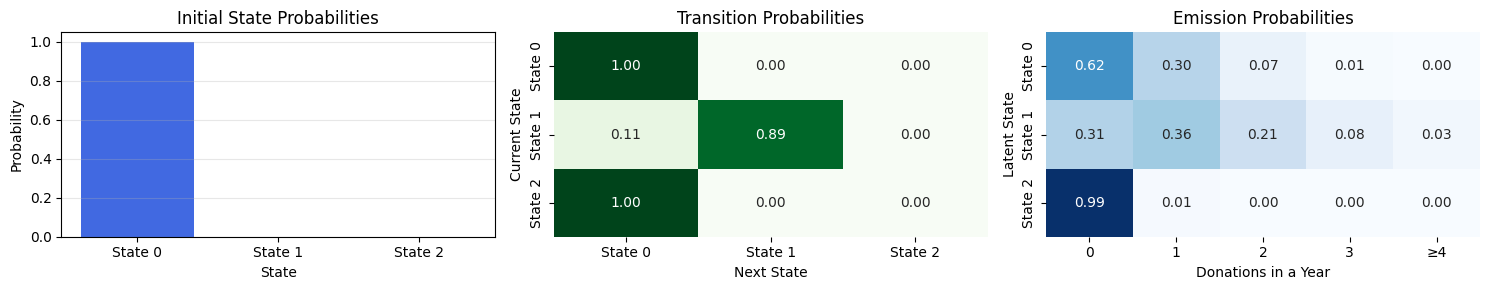

In [9]:
# ───────────────────────── DIAGNOSTICA ─────────────────────
from scipy.stats import poisson     # solo per la matrice di emissione

# parametri stimati dell’emissione Poisson
rate_hat = pyro.param("rate").detach().cpu().numpy()      # (K,)

# media (e varianza) del conteggio = λ per Poisson
mu_hat = rate_hat.copy()

# iniziali e transizioni (come prima)
init_log  = pyro.param("state_init_logits").detach().cpu().numpy()
init_prob = np.exp(init_log) / np.exp(init_log).sum()

W = pyro.param("trans_W").detach().cpu().numpy()          # (K,K,C)
b = pyro.param("trans_b").detach().cpu().numpy()          # (K,K)
cov_mean = full_cov_torch[:, 0, :].mean(0).cpu().numpy()

P = np.zeros((K, K))
for k in range(K):
    logits = b[k] + W[k] @ cov_mean
    P[k]   = np.exp(logits) / np.exp(logits).sum()

print("\nPoisson per stato:")
for k in range(K):
    print(f"  stato {k}: λ={rate_hat[k]:.3f}  E[X]={mu_hat[k]:.3f}")
print("\nProbabilità iniziali:", init_prob)
print("Matrice di transizione (media covariate):\n", P)

# ───────────────────── EMISSION MATRIX (opz.) ──────────────
# 5 categorie: 0,1,2,3,≥4  (quindi l’ultima è la coda)
def build_emission_matrix_truncated_poisson(rate, max_k=4):
    S = len(rate)
    Kc = max_k          # 0 … max_k-1   (qui 0–3)
    M  = np.zeros((S, Kc + 1))
    for s in range(S):
        for k in range(Kc):
            M[s, k] = poisson.pmf(k, rate[s])
        # ultima colonna = coda P(X ≥ max_k)
        M[s, Kc] = 1 - poisson.cdf(Kc - 1, rate[s])
    return M

emission_mat = build_emission_matrix_truncated_poisson(rate_hat, max_k=4)

plot_hmm_params(transitions=P,
    initial_probs=init_prob,
    emissions=emission_mat,
    emission_names=[str(i) for i in range(4)] + ["≥4"])

## HMM with covariates


In [4]:
# ──────────────────────────────────────────────────────────────
#  Poisson-HMM con covariate (5 covariate già normalizzate)
# ──────────────────────────────────────────────────────────────
import torch, pyro, pyro.distributions as dist
from   pyro.infer        import SVI, TraceEnum_ELBO, config_enumerate
from   pyro.optim        import Adam

K = 3                       # n. stati latenti
C = full_cov_torch.size(-1) # = 5  (birth_year_norm, gender, age_norm, covid, const)

# --------------------------------------------------------------
# MODEL
# --------------------------------------------------------------
@config_enumerate
def model(obs, cov):
    N, T = obs.shape

    # ① Emissioni Poisson (state-specific)
    rates = pyro.param("rates",
                       torch.ones(K),
                       constraint=dist.constraints.positive)          # λ_k

    # ② Logit-coeff per π (soft-max sulle covariate del primo anno)
    W0 = pyro.param("W0", torch.zeros(K, C))                          # (K,C)
    b0 = pyro.param("b0", torch.zeros(K))                             # (K,)

    # ③ Logit-coeff per la transition matrix
    W  = pyro.param("W", torch.zeros(K, K, C))                        # (K,K,C)
    b  = pyro.param("b", torch.zeros(K, K))                           # (K,K)

    with pyro.plate("donors", N):
        # ---------- stato iniziale ----------------------------------
        logits0 = cov[:, 0, :] @ W0.T + b0            # shape (N,K)
        z_prev  = pyro.sample("z_0",
                              dist.Categorical(logits=logits0),
                              infer={"enumerate": "parallel"})

        # ---------- emissione t = 0 ---------------------------------
        pyro.sample("y_0",
                    dist.Poisson(rates[z_prev]),
                    obs=obs[:, 0])

        # ---------- loop temporale t = 1 … T-1 -----------------------
        for t in range(1, T):
            x_t     = cov[:, t, :]                                       # (N,C)
            logitsT = (W[z_prev] * x_t[:, None, :]).sum(-1) + b[z_prev]  # (N,K)
            z_t = pyro.sample(f"z_{t}",
                              dist.Categorical(logits=logitsT),
                              infer={"enumerate": "parallel"})

            pyro.sample(f"y_{t}",
                        dist.Poisson(rates[z_t]),
                        obs=obs[:, t])
            z_prev = z_t


# --------------------------------------------------------------
# GUIDE: mean-field sui soli parametri globali (z enumerati)
# --------------------------------------------------------------
def guide(obs, cov):
    # Nessun campionamento: tutti i parametri sono pyro.param nel model
    pass


# --------------------------------------------------------------
# TRAINING
# --------------------------------------------------------------
pyro.clear_param_store()
svi = SVI(model, guide,
          Adam({"lr": 0.05}),
          loss=TraceEnum_ELBO(max_plate_nesting=1))

for step in range(1000):
    loss = svi.step(obs_torch, full_cov_torch)
    if step % 100 == 0:
        print(f"{step:4d}  ELBO = {loss:,.0f}")

   0  ELBO = 177,716
 100  ELBO = 126,009
 200  ELBO = 124,338
 300  ELBO = 123,852
 400  ELBO = 123,763
 500  ELBO = 123,726
 600  ELBO = 123,706
 700  ELBO = 123,694
 800  ELBO = 123,687
 900  ELBO = 123,682


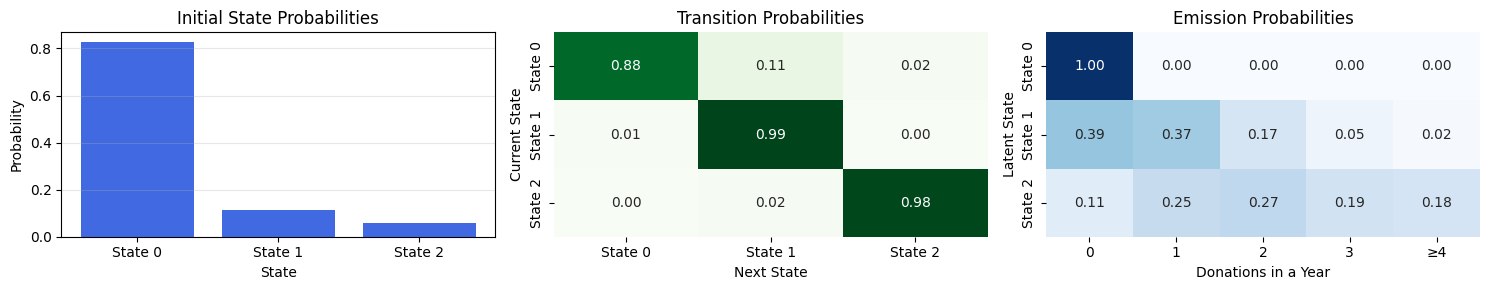

In [10]:
# ── 1. parametri stimati ──────────────────────────────────────────
lam = pyro.param("rates").detach().cpu().numpy()      # (K,)
W0  = pyro.param("W0").detach().cpu().numpy()         # (K,C)
b0  = pyro.param("b0").detach().cpu().numpy()         # (K,)
W   = pyro.param("W").detach().cpu().numpy()          # (K,K,C)
b   = pyro.param("b").detach().cpu().numpy()          # (K,K)

# ── 2. covariate di riferimento (media popolazione) ───────────────
x_mean_all  = full_cov_torch.mean((0,1)).cpu().numpy()   # (C,)
x_mean_t0   = full_cov_torch[:,0,:].mean(0).cpu().numpy()

# ── 3. π̄ e Ā  ------------------------------------------------------
def softmax_row(v):                     # v shape (...,K)
    e = np.exp(v - v.max(-1,keepdims=True))
    return e / e.sum(-1,keepdims=True)

pi_mean = softmax_row(b0 + W0 @ x_mean_t0)             # (K,)
A_mean  = np.zeros((K,K))
for k in range(K):
    A_mean[k] = softmax_row(b[k] + W[k] @ x_mean_all)   # (K,)

# ── 4. matrice di emissione Poisson troncata a 0…4 ────────────────
from scipy.stats import poisson
def build_emission_matrix_truncated_poisson(rates, max_k=4):
    S, K = len(rates), max_k + 1
    M = np.zeros((S, K))
    for s in range(S):
        for k in range(max_k):
            M[s,k] = poisson.pmf(k, rates[s])
        M[s,max_k] = 1 - poisson.cdf(max_k - 1, rates[s])
    return M

emissions_matrix = build_emission_matrix_truncated_poisson(lam, 4)

# ── 5. plot  -------------------------------------------------------
plot_hmm_params(
    transitions     = A_mean,
    initial_probs   = pi_mean,
    emissions       = emissions_matrix,
    emission_names  = [str(i) for i in range(4)] + ["≥4"]
)

In [13]:
import torch, pyro, torch.nn.functional as F
import pyro.distributions as dist

# ------------------------------------------------------------------
#  utility: soft-max che restituisce già il log-prob
# ------------------------------------------------------------------
def log_softmax_logits(logits, dim=-1):
    return logits - logits.logsumexp(dim, keepdim=True)

# ------------------------------------------------------------------
#  decoder Viterbi per modello con covariate
# ------------------------------------------------------------------
def viterbi_paths_covariate(obs, cov, K=3):
    """
    Restituisce il percorso MAP (tensor [N,T]) per ogni individuo
    nel Covariate-Poisson-HMM.
    """
    with torch.no_grad():
        N, T        = obs.shape
        C           = cov.size(-1)

        # ----------- parametri appresi ---------------------------------
        lam         = pyro.param("rates")           # [K]
        W0          = pyro.param("W0")              # [K,C]
        b0          = pyro.param("b0")              # [K]
        W           = pyro.param("W")               # [K,K,C]
        b           = pyro.param("b")               # [K,K]

        # ----------- emission log-prob ---------------------------------
        emis_log = torch.stack(
            [dist.Poisson(l).log_prob(obs) for l in lam]   # [K,N,T]
        ).permute(1, 2, 0)                                 # [N,T,K]

        # ----------- inizializzazione delta ----------------------------
        log_pi  = log_softmax_logits(cov[:, 0, :] @ W0.T + b0)   # [N,K]
        delta   = log_pi + emis_log[:, 0]                        # [N,K]
        psi     = torch.zeros(N, T, K, dtype=torch.long)

        # ----------- forward pass t = 1 … T-1 --------------------------
        for t in range(1, T):
            x_t   = cov[:, t, :]                                 # (N,C)
            # log-matrici di transizione dipendenti da z_prev
            #   logits[n, k_prev, k_next] = (W[k_prev,k_next]·x_t) + b[k_prev,k_next]
            logits = (W.unsqueeze(0) * x_t[:, None, None, :]).sum(-1) + b
            log_A  = log_softmax_logits(logits, dim=2)           # (N,K,K)

            score, idx = (delta.unsqueeze(2) + log_A).max(1)     # max su k_prev
            psi[:, t]   = idx                                    # store argmax
            delta       = score + emis_log[:, t]                 # update delta

        # ----------- back-tracking ------------------------------------
        paths       = torch.empty(N, T, dtype=torch.long)
        last_state  = delta.argmax(1)
        paths[:, -1] = last_state
        for t in range(T-1, 0, -1):
            last_state         = psi[torch.arange(N), t, last_state]
            paths[:, t-1]      = last_state

        return paths

paths = viterbi_paths_covariate(obs_torch, full_cov_torch, K=3)

switch_rate = (paths[:,1:] != paths[:,:-1]).any(1).float().mean()
print(f"switch rate = {switch_rate:.2%}")

switch rate = 75.43%


##### State occupancy over time (population view)

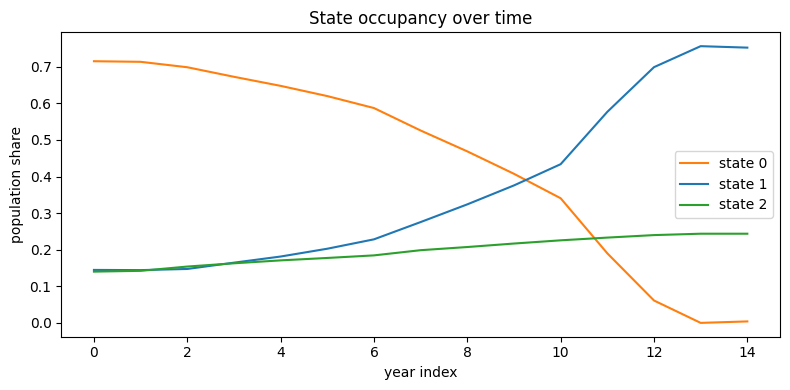

In [14]:
counts = np.apply_along_axis(lambda col: np.bincount(col, minlength=3),
                             0, paths)          # (K,T)
props  = counts / counts.sum(0, keepdims=True)

plt.figure(figsize=(8,4))
for k,c in enumerate(['tab:orange','tab:blue','tab:green']):
    plt.plot(props[k], label=f'state {k}', color=c)
plt.xlabel('year index'); plt.ylabel('population share')
plt.title('State occupancy over time'); plt.legend(); plt.tight_layout()

##### Rates with confidence bands

In [ ]:

rate_sd   = np.sqrt(pyro.param("lam").detach().numpy()) / pyro.param("r_beta").detach().numpy()
ci = 1.96 * rate_sd
plt.errorbar(np.arange(K), rates, yerr=ci, fmt='o')
plt.xticks(range(K)); plt.ylabel('λ'); plt.title('Poisson rates with 95% CI')

KeyError: 'r_alpha'

##### Network / chord diagram of transitions

A visual alternative to the heat-map, highlights main flows.

C:\Users\erik4\AppData\Local\Programs\Python\Python313\Lib\site-packages\networkx\drawing\nx_pylab.py:457: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


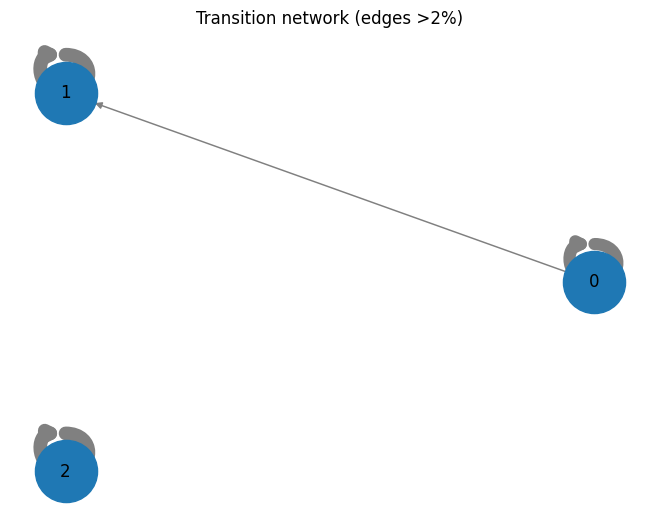

In [16]:
import networkx as nx
G = nx.DiGraph()
for i in range(K):
    for j in range(K):
        if A_mean[i,j] > 0.02:                 # ignore tiny flows
            G.add_edge(i, j, weight=A_mean[i,j])
pos = nx.circular_layout(G)
weights = [G[u][v]['weight']*10 for u,v in G.edges]
nx.draw(G, pos, with_labels=True, width=weights,
        edge_color='grey', node_size=2000, cmap='viridis')
plt.title('Transition network (edges >2%)'); plt.show()

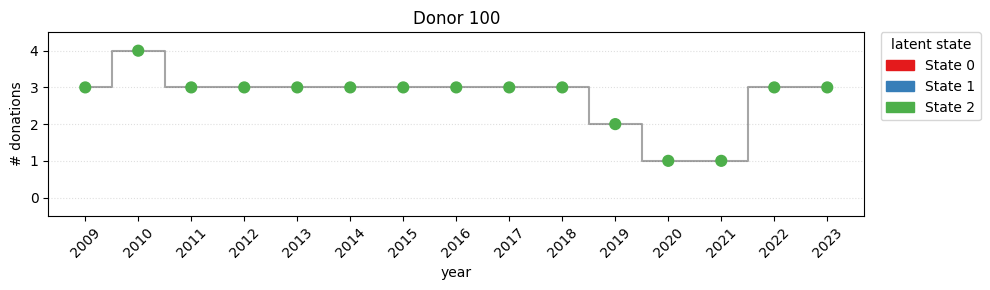

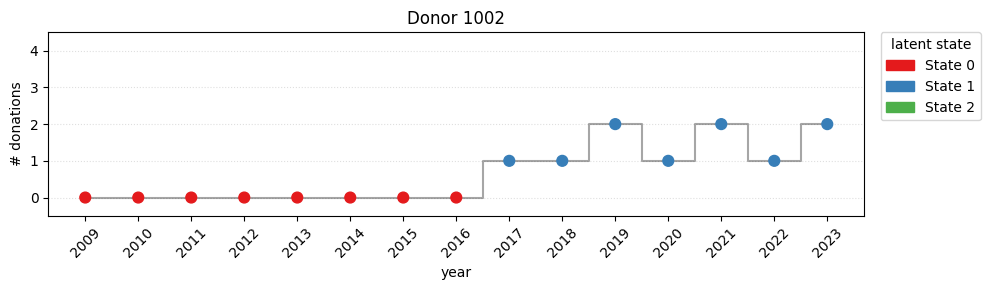

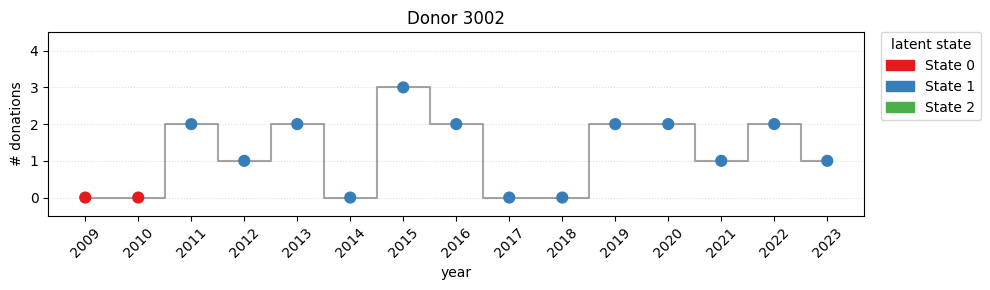

In [17]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.patches import Patch
import numpy as np

# ------------------------------------------------------------
# globals
# ------------------------------------------------------------
K           = 3
state_cols  = ['#e41a1c', '#377eb8', '#4daf4a']          # 3 colori Set1
cmap        = ListedColormap(state_cols)
norm        = BoundaryNorm(np.arange(-0.5, K+0.5, 1), cmap.N)
years_axis  = np.arange(2009, 2024)                      # 2009 .. 2024
yticks_vals = np.arange(0, 5)                            # 0 .. 4

# ------------------------------------------------------------
def plot_one(idx):
    x = obs_torch[idx].cpu().numpy()       # osservazioni (T,)
    z = paths[idx]                         # stati latenti (T,)
    T = len(x)
    assert T == len(years_axis), "years_axis length must match T"

    plt.figure(figsize=(10, 3))
    plt.scatter(range(T), x, c=z, cmap=cmap, norm=norm, s=60, zorder=3)
    plt.step(range(T), x, where='mid', color='k', alpha=.35, zorder=2)

    # ---------- axis formatting ----------------------------------------
    plt.xticks(ticks=range(T), labels=years_axis, rotation=45)
    plt.yticks(ticks=yticks_vals)
    plt.ylim(-0.5, 4.5)                     # blocca a 0–4
    plt.grid(axis='y', linestyle=':', alpha=.4, zorder=1)

    # ---------- legenda discreta ---------------------------------------
    handles = [Patch(color=state_cols[k], label=f'State {k}') for k in range(K)]
    plt.legend(handles=handles, title='latent state',
               bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0.)

    plt.title(f'Donor {idx}')
    plt.xlabel('year')
    plt.ylabel('# donations')
    plt.tight_layout()
    plt.show()


for i in [100, 1002, 3002]:
    plot_one(i)

##### Stationary distribution vs initial π

Compute the stationary distribution of A and plot both as bars.

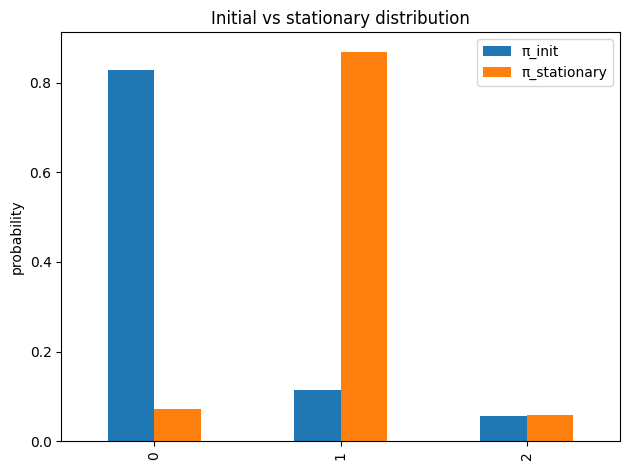

In [18]:
w, v = np.linalg.eig(A_mean.T)
stationary = np.real(v[:,np.isclose(w,1)].flatten())
stationary /= stationary.sum()
df = pd.DataFrame({'π_init':pi_mean, 'π_stationary':stationary})
df.plot(kind='bar'); plt.ylabel('probability')
plt.title('Initial vs stationary distribution'); plt.tight_layout()

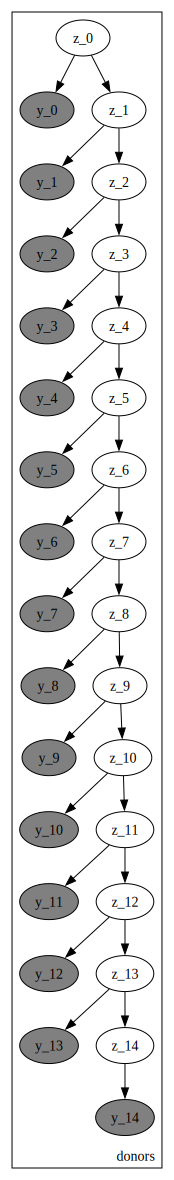

In [21]:
import pyro
from pyro import render_model

# usiamo solo i primi  2  donatori per non disegnare un grafo enorme
example_obs  = obs_torch[:2]
example_cov  = full_cov_torch[:2]

# Draw the plate & sample structure; include dists and params.
render_model(
    model,
    model_args=(example_obs, example_cov),
    # render_distributions=True,
    # render_params=True,
    filename="cov_hmm.gv"    # produce cov_hmm.gv e PNG/SVG
)

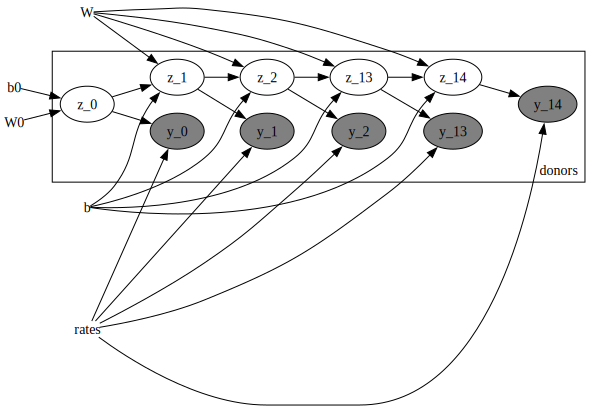

In [30]:
# ────────────────────────────────────────────────────────────────
#  Wrapper "sketch_model" – mostra z0,y0,z1,y1,      zT-2,yT-2,zT-1,yT-1
# ────────────────────────────────────────────────────────────────
def sketch_model(obs, cov, show_first=3, show_last=2):
    """
    Clona la logica del vero modello ma esegue soltanto
    i primi `show_first` e gli ultimi `show_last` passi temporali.
    Serve unicamente per pyro.render_model().
    """
    N, T = obs.shape
    rates = pyro.param("rates")
    W0, b0 = pyro.param("W0"), pyro.param("b0")
    W,  b  = pyro.param("W"),  pyro.param("b")

    with pyro.plate("donors", N):
        # ----- t = 0 -------------------------------------------------
        logits0 = cov[:, 0, :] @ W0.T + b0
        z_prev  = pyro.sample("z_0", dist.Categorical(logits=logits0))
        pyro.sample("y_0", dist.Poisson(rates[z_prev]), obs=obs[:, 0])

        # ----- loop t = 1 … T-1 --------------------------------------
        for t in range(1, T):
            if not (t < show_first or t >= T - show_last):
                continue             # salta i passi centrali

            x_t     = cov[:, t, :]
            logitsT = (W[z_prev] * x_t[:, None, :]).sum(-1) + b[z_prev]
            z_t     = pyro.sample(f"z_{t}", dist.Categorical(logits=logitsT))
            pyro.sample(f"y_{t}", dist.Poisson(rates[z_t]), obs=obs[:, t])
            z_prev = z_t

# usiamo un mini-batch di 2 individui giusto per il diagramma
ex_obs = obs_torch[:2]
ex_cov = full_cov_torch[:2]

g = render_model(sketch_model,
                 model_args=(ex_obs, ex_cov),
                #  render_distributions=True,
                 render_params=True)    # non passo filename → ottengo l’oggetto

g.graph_attr["rankdir"] = "LR"  
g